In [1]:
# using a histogram to record the frequnetly query region
# when split according to query, only query in the above region is considered
# for other region, perform LKD? or KD

In [2]:
# NORA kdnode format
# [domain, #records, self_id, parent_id, left_child_id, right_child_id] -1 denotes invalid id
# domain: [dimension][min, max]

In [3]:
import import_ipynb
import numpy as np
import copy
import rtree
from rtree import index
import math

In [4]:
# assume hist is 2D

# dataset = [[0,0],[0,2],[2,0],[2,0],[2,2],[2,2],[2,2]]
# dataset = np.array(dataset)
# hist, edges = np.histogramdd(dataset, bins = (2,2))
# array([[1., 1.],
#        [2., 3.]])

# dataset = [[0,0,0],[0,2,0],[2,0,0],[2,0,0],[2,2,0],[2,2,0],[2,2,2]]
# dataset = np.array(dataset)
# hist, edges = np.histogramdd(dataset, bins = (2,2,2))
# array([[0, 0, 0],
#        [1, 1, 1],
#        [2, 2, 2]])

# This np.histogramdd has the same idea as ours, i.e., the last dim is nested within the former dimension

# aim to SUPPORT multi dimension
def CreatePrefixSumHist(hist):
    '''
    @hist: notice the input should only contain values instead of set(), i.e., not from GetEmptyHist()
    return
    Notice the input of this function should be similar to np.histogramdd(dataset, bins = (...))
    '''
    # in case it's not in np
    hist = np.array(hist)
    for k in reversed(range(len(hist.shape))):
        buckets = hist.shape[k]
        for i in range(1,buckets):
            # https://stackoverflow.com/questions/42817508/get-the-i-th-slice-of-the-k-th-dimension-in-a-numpy-array
            hist[(slice(None),) * k + (i,)] += hist[(slice(None),) * k + (i-1,)]
            #hist[(slice(None),) * 1 + (slice(1, 2, 1),)] # start (inclusive), end (exclusive), stride  for range
    return hist

# def CreatePrefixSumHist(hist):
#     '''
#     Notice the input of this function should be np.histogramdd(dataset, bins = (...))
#     '''
#     # in case it's not in np
#     hist = np.array(hist)
    
#     # accumulation in second dimension
#     for i in range(hist.shape[0]):
#         for j in range(1,hist.shape[1]):
#             hist[i,j] += hist[i,j-1]
    
#     # now do the accumulation in first dimension
#     for j in range(hist.shape[1]):
#         for i in range(1,hist.shape[0]):
#             hist[i,j] += hist[i-1,j]
            
#     return hist


# def CreatePrefixSumHist3D(hist):
    
#     # in case it's not in np
#     hist = np.array(hist)
    
#     # accumulation on the third dimension
#     for i in range(hist.shape[0]):
#         for j in range(hist.shape[1]):
#             for k in range(1,hist.shape[2]):
#                 hist[i,j,k] += hist[i,j,k-1]
    
#     # now do the accumulation on the second dimension
#     for k in range(hist.shape[2]):
#         for i in range(hist.shape[0]):
#             for j in range(1,hist.shape[1]):
#                 hist[i,j,k] += hist[i,j-1,k]
    
#     # now do the accumulation on the first dimension
#     for j in range(hist.shape[1]):
#         for k in range(hist.shape[2]):
#             for i in range(1,hist.shape[0]):
#                 hist[i,j,k] += hist[i-1,j,k]
            
#     return hist


# aim to SUPPORT multi dimension
def QueryAccuHist(accu_hist, query, domain):
    '''
    the accu_hist should be numpy array
    all arguments should have the same dimensions and order
    
    The algorithm could be found in "Range Queries in OLAP Data Cube", SIGMOD 1997, Page 3, Equation 2
    '''
    dims = len(domain)
    dim_steps = [(domain[k][1] - domain[k][0]) / accu_hist.shape[k] for k in range(dims)]
    query_index_min = [int((query[k][0] - domain[k][0]) / dim_steps[k])-1 for k in range(dims)] # notice there should be -1 here 
    query_index_max = [int((query[k][1] - domain[k][0]) / dim_steps[k]) for k in range(dims)]
    query_index_min = [min(query_index_min[k], accu_hist.shape[k]-1) for k in range(dims)]
    query_index_max = [min(query_index_max[k], accu_hist.shape[k]-1) for k in range(dims)]
    
    approximate_result = 0
    for value in range(0, 2**dims):
        
        ignore_flag = False # to skip those 0 accumulation point
        
        # used to denotes the upper and lower end
        query_expr = bin(value).split('b')[1]
        query_expr = '0'*(dims - len(query_expr)) + query_expr # add 0s at the front to make the dimensions consistent
        low_count = query_expr.count('0')
        
        # find the corresponding sign
        sign = 1
        if low_count % 2 != 0:
            sign = -1
            
        # find corresponding index of the prefix sum array
        indexes = ()
        for k in range(dims):
            if query_expr[dims-k-1] == '0':
                if query_index_min[k] < 0:
                    ignore_flag = True
                    break # this accumulation is 0
                indexes += (slice(query_index_min[k], query_index_min[k]+1, 1),) # the 1 here is stride
            else:
                indexes += (slice(query_index_max[k], query_index_max[k]+1, 1),)
        
        # calculate the result for this one
        if not ignore_flag:
            approximate_result += sign * accu_hist[indexes]
            
    return float(approximate_result)

# equal_width histogram, for 2D
# query is in the form of kdnode[0], domain indicate the global domain, also in the form of kdnode[0]
def QueryAccuHist2D(accu_hist, query, domain):
    
    bins = accu_hist.shape
    
    dim_1_lower_index = int((query[0][0]-domain[0][0])/(domain[0][1]-domain[0][0])*bins[0])
    dim_1_upper_index = int((query[0][1]-domain[0][0])/(domain[0][1]-domain[0][0])*bins[0])
    dim_2_lower_index = int((query[1][0]-domain[1][0])/(domain[1][1]-domain[0][0])*bins[1])
    dim_2_upper_index = int((query[1][1]-domain[1][0])/(domain[1][1]-domain[0][0])*bins[1])
    
    if dim_1_lower_index >= bins[0]:
        dim_1_lower_index = bins[0] - 1
    
    if dim_1_upper_index >= bins[0]:
        dim_1_upper_index = bins[0] - 1
        
    if dim_2_lower_index >= bins[1]:
        dim_2_lower_index = bins[1] - 1
        
    if dim_2_upper_index >= bins[1]:
        dim_2_upper_index = bins[1] - 1
    
    d1L_d2L = accu_hist[dim_1_lower_index, dim_2_lower_index]
    d1L_d2U = accu_hist[dim_1_lower_index, dim_2_upper_index]
    d1U_d2L = accu_hist[dim_1_upper_index, dim_2_lower_index]
    d1U_d2U = accu_hist[dim_1_upper_index, dim_2_upper_index]
    
    print('dim1L_idx:',dim_1_lower_index,"dim1U_idx:",dim_1_upper_index,"dim2L_idx:",dim_2_lower_index,"dim2U_idx:",dim_2_upper_index)
    result = d1U_d2U - d1U_d2L - d1L_d2U + d1L_d2L
    return result

def generate_candidate_cut_pos(queryset):
    '''
    @parameter: queryset
    @return: candiate cut position
    '''
    candidate_cut_pos = []
    for i in range(len(queryset)):
        for j in range(len(queryset[i])):
            candidate_cut_pos.append((j, queryset[i][j][0]))
            candidate_cut_pos.append((j, queryset[i][j][1]))      
    return candidate_cut_pos

def DatasetGenerator(queryset):
    for i in range(len(queryset)):
        lower = [domain[0] for domain in queryset[i]]
        upper = [domain[1] for domain in queryset[i]]
        border = tuple(lower + upper) # non interleave
        yield(i, border, queryset[i])
    return


def skip_for_split(queryset, kdnode, idx):
    count_skip = len(queryset) * kdnode[1] # this is incorrect
    lower = [domain[0] for domain in kdnode[0]]
    upper = [domain[1] for domain in kdnode[0]]
    for i in range(len(lower)):
        if lower[i] >= upper[i]:
            print(lower, upper)
            print(kdnode)
    border = tuple(lower + upper) # non interleave
    overlapped_query_id = list(idx.intersection(border))
    count_skip -= kdnode[1] * len(overlapped_query_id)
    return count_skip


def skip_gain_for_split(original_node, child_node1, child_node2, queryset, idx):
    # original node
    lower0 = [domain[0] for domain in original_node[0]]
    upper0 = [domain[1] for domain in original_node[0]]
    border0 = tuple(lower0 + upper0)
    overlapped_query_id0 = list(idx.intersection(border0))
    original_overlap = original_node[1] * len(overlapped_query_id0)
    
    # child node 1
    lower1 = [domain[0] for domain in child_node1[0]]
    upper1 = [domain[1] for domain in child_node1[0]]
    border1 = tuple(lower1 + upper1)
    overlapped_query_id1 = list(idx.intersection(border1))
    child_node1_overlap = child_node1[1] * len(overlapped_query_id1)
    
    # child node 2
    lower2 = [domain[0] for domain in child_node2[0]]
    upper2 = [domain[1] for domain in child_node2[0]]
    border2 = tuple(lower2 + upper2)
    overlapped_query_id2 = list(idx.intersection(border2))
    child_node2_overlap = child_node2[1] * len(overlapped_query_id2)
    
    skip_gain = original_overlap - child_node1_overlap - child_node2_overlap
    return skip_gain


def perform_split(i, kdnodes, max_skip_dim, max_skip_value, temp_dataset, dataset_dict, kdnode_dict, accu_count):
    sub_domains1 = np.copy(kdnodes[i][0])
    sub_domains1[max_skip_dim][1] = max_skip_value - 0.00001
    sub_domains2 = np.copy(kdnodes[i][0])
    sub_domains2[max_skip_dim][0] = max_skip_value + 0.00001

    sub_dataset1 = temp_dataset[temp_dataset[:,max_skip_dim] <= max_skip_value]
    sub_dataset2 = temp_dataset[temp_dataset[:,max_skip_dim] > max_skip_value]
    sub_dataset1_size = len(sub_dataset1)
    sub_dataset2_size = len(sub_dataset2)
    
    parent_node_id = kdnodes[i][-4]
    sub_kdnodes_1 = [sub_domains1, sub_dataset1_size, accu_count + 1, parent_node_id, -1, -1]
    sub_kdnodes_2 = [sub_domains2, sub_dataset2_size, accu_count + 2, parent_node_id, -1, -1]
    
    kdnode_dict[parent_node_id][-2] = accu_count + 1
    kdnode_dict[parent_node_id][-1] = accu_count + 2
    #kdnode_dict.update({accu_count + 1: copy.deepcopy(sub_kdnodes_1)}) 
    #kdnode_dict.update({accu_count + 2: copy.deepcopy(sub_kdnodes_2)}) 
    kdnode_dict.update({accu_count + 1: sub_kdnodes_1}) 
    kdnode_dict.update({accu_count + 2: sub_kdnodes_2}) 

    kdnodes[i] = sub_kdnodes_1
    dataset_dict.update({i:sub_dataset1}) # one put in the original place
    kdnodes.append(sub_kdnodes_2)
    dataset_dict.update({len(kdnodes)-1:sub_dataset2}) # the other put in the end
    

# this idx is index for query!!!
def try_split(kdnode, candidate_cut, temp_dataset, queryset, idx, min_block_size):
    split_dimension = candidate_cut[0]
    split_value = candidate_cut[1]
    
    #sub_dataset1 = temp_dataset[temp_dataset[:,split_dimension] <= split_value]  # process time: 0.019
    #sub_dataset2 = temp_dataset[temp_dataset[:,split_dimension] > split_value]
    #sub_dataset1 = temp_dataset  # used to test whether the above operation is too slow, and it is too slow!
    #sub_dataset2 = temp_dataset

    # check if the subnodes greater than threshold
    #sub_dataset1_size = len(sub_dataset1)
    sub_dataset1_size = np.count_nonzero(temp_dataset[:,split_dimension] <= split_value) # process time: 0.007
    sub_dataset2_size = kdnode[1] - sub_dataset1_size

    if sub_dataset1_size < min_block_size or sub_dataset2_size < min_block_size:
        return False, 0
    
    temp_sub_domains1 = np.copy(kdnode[0])
    temp_sub_domains1[split_dimension][1] = split_value
    temp_sub_domains2 = np.copy(kdnode[0])
    temp_sub_domains2[split_dimension][0] = split_value
 
    temp_sub_kdnodes_1 = [temp_sub_domains1, sub_dataset1_size]
    temp_sub_kdnodes_2 = [temp_sub_domains2, sub_dataset2_size]
    
    if temp_sub_domains1[split_dimension][1] < temp_sub_domains1[split_dimension][0] or \
    temp_sub_domains2[split_dimension][0] > temp_sub_domains2[split_dimension][1]:
        return False, 0
    
    skip_gain = skip_gain_for_split(kdnode, temp_sub_kdnodes_1, temp_sub_kdnodes_2, queryset, idx)
    return True, skip_gain
    
    #count_skip = skip_for_split(queryset, temp_sub_kdnodes_1, idx) + skip_for_split(queryset, temp_sub_kdnodes_2, idx)
    #return True, count_skip
    

# this idx is index for query!!!
def try_split_approximate(kdnode, candidate_cut, queryset, idx, min_block_size, accu_hist, domain):
    split_dimension = candidate_cut[0]
    split_value = candidate_cut[1]
    
    temp_sub_domains1 = np.copy(kdnode[0])
    temp_sub_domains1[split_dimension][1] = split_value - 0.00001
    temp_sub_domains2 = np.copy(kdnode[0])
    temp_sub_domains2[split_dimension][0] = split_value + 0.00001 # this is used to avoid being recognized as intersection
    
    if temp_sub_domains1[split_dimension][1] < temp_sub_domains1[split_dimension][0] or \
    temp_sub_domains2[split_dimension][0] > temp_sub_domains2[split_dimension][1]:
        return False, 0
    
    # check if the subnodes greater than threshold
    sub_dataset1_size = QueryAccuHist(accu_hist, temp_sub_domains1, domain)
    #sub_dataset2_size = QueryAccuHist(accu_hist, temp_sub_domains2, domain)
    sub_dataset2_size = kdnode[1] - sub_dataset1_size

    if sub_dataset1_size < min_block_size or sub_dataset2_size < min_block_size:
        return False, 0
    
    temp_sub_kdnodes_1 = [temp_sub_domains1, sub_dataset1_size]
    temp_sub_kdnodes_2 = [temp_sub_domains2, sub_dataset2_size]
    
    # this is incorrect
    #count_skip = skip_for_split(queryset, temp_sub_kdnodes_1, idx) + skip_for_split(queryset, temp_sub_kdnodes_2, idx)
    
    skip_gain = skip_gain_for_split(kdnode, temp_sub_kdnodes_1, temp_sub_kdnodes_2, queryset, idx)
    
    return True, skip_gain

In [5]:
def kdnode_2_border(kdnode):
    lower = [domain[0] for domain in kdnode[0]]
    upper = [domain[1] for domain in kdnode[0]]
    border = tuple(lower + upper) # non interleave
    return border

def query_2_border(query):
    lower = [domain[0] for domain in query]
    upper = [domain[1] for domain in query]
    border = tuple(lower + upper) # non interleave
    return border

def GetEmptyHist2D(m, n):
    hist = []
    for i in range(m):
        hist.append([])
        for j in range(n):
            hist[i].append([0,set()])
    return hist

# recursive, too slow
# def GetEmptyHist(buckets=[1000, 1000], level = 0):
    
#     if level == len(buckets):
#         return [0,set()]
    
#     hist = []
#     sub_hist = GetEmptyHist(buckets, level+1)
#     hist = [sub_hist for i in range(buckets[level])]
    
#     return hist

# could SUPPORT any dimensions
def GetEmptyHist(buckets=[1000, 1000]):
    '''
    return the hist as numpy array
    '''
    prev_hist = []
    sub_hist = [0,set()] # the bottom element
    for k in reversed(range(len(buckets))):
        prev_hist = [copy.deepcopy(sub_hist) for i in range(buckets[k])]  # without copy the set will be the same
        sub_hist = prev_hist
    prev_hist = np.array(prev_hist)
    return prev_hist

def InserQueryIntoHist2D(index, SingleQuery, hist, domain, m, n, threshold):

    dim1_step = (domain[0][1]-domain[0][0])/m
    dim2_step = (domain[1][1]-domain[1][0])/n
    
    dim1_index_min = int((SingleQuery[0][0] - domain[0][0]) / dim1_step)
    dim1_index_max = int((SingleQuery[0][1] - domain[0][0]) / dim1_step)
    dim2_index_min = int((SingleQuery[1][0] - domain[1][0]) / dim1_step)
    dim2_index_max = int((SingleQuery[1][1] - domain[1][0]) / dim1_step)
    
    if dim1_index_min >= m:
        dim1_index_min = m-1
    if dim1_index_max >= m:
        dim1_index_max = m-1
    if dim2_index_min >= n:
        dim2_index_min = n-1
    if dim2_index_max >= n:
        dim2_index_max = n-1
        
    # also need to check whether a region just become a distribution query region
    distribution_regions = []
    for m in range(dim1_index_min, dim1_index_max+1):
        for n in range(dim2_index_min, dim2_index_max+1):
            hist[m][n][0] += 1
            hist[m][n][1].add(index)
            if hist[m][n][0]-1 < threshold and hist[m][n][0] >= threshold: # whether a region just become distribution query region
                distribution_regions.append((m,n))
            
    return distribution_regions
            
    
def select_suffix(index_min, index_max, last_dim = -1):
    '''
    @index_min[]: the start index at each dimension
    @index_max[]: the end index (exclusive) at each dimension
    '''
    indexes = ()
    for k in range(len(index_min)):
        indexes += (slice(index_min[k], index_max[k], 1),) # the 1 here is stride
    
    if last_dim != -1:
        indexes += (slice(last_dim, last_dim+1, 1),)
    #print(indexes)
    return indexes
    
# aim to SUPPORT multi dimensions
def InserQueryIntoHist(qid, SingleQuery, hist, domain, threshold, buckets=[1000, 1000], return_new_region = False):

    '''
    hist should be a np.array
    query, hist, domain, and buckets should have the same dimensions (and order)
    '''
    dims = len(domain)
    
    dim_steps = [(domain[k][1] - domain[k][0]) / buckets[k] for k in range(dims)]
    #print("dim steps:", dim_steps)
    query_index_min = [int((SingleQuery[k][0] - domain[k][0]) / dim_steps[k]) for k in range(dims)]
    query_index_max = [int((SingleQuery[k][1] - domain[k][0]) / dim_steps[k]) + 1 for k in range(dims)]
    # because we use range selection in the following, we need to add 1 to include the original index
    
    query_index_min = [min(query_index_min[k], buckets[k]-1) for k in range(dims) ]
    query_index_max = [min(query_index_max[k], buckets[k]-1) for k in range(dims) ]
   
    suffix_count = select_suffix(query_index_min, query_index_max, 0)
    hist[suffix_count] += 1
    
    suffix_set = select_suffix(query_index_min, query_index_max, 1)
    set_add = lambda t: t.add(qid)
    vfunc = np.vectorize(set_add) # https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array
    vfunc(hist[suffix_set])
    
    new_distribution_regions = None
    if return_new_region:
        new_distribution_regions = np.argwhere(hist == threshold) # whether a region just become distribution query region
        new_distribution_regions = [tuple(new_distribution_regions[i]) for i in range(len(new_distribution_regions))]
            
    return new_distribution_regions    

            
def RemoveQueryFromHist2D(index, SingleQuery, hist, domain, m, n, threshold):
    
    dim1_step = (domain[0][1]-domain[0][0])/m
    dim2_step = (domain[1][1]-domain[1][0])/n
    
    dim1_index_min = int((SingleQuery[0][0] - domain[0][0]) / dim1_step)
    dim1_index_max = int((SingleQuery[0][1] - domain[0][0]) / dim1_step)
    dim2_index_min = int((SingleQuery[1][0] - domain[1][0]) / dim1_step)
    dim2_index_max = int((SingleQuery[1][1] - domain[1][0]) / dim1_step)
    
    if dim1_index_min >= m:
        dim1_index_min = m-1
    if dim1_index_max >= m:
        dim1_index_max = m-1
    if dim2_index_min >= n:
        dim2_index_min = n-1
    if dim2_index_max >= n:
        dim2_index_max = n-1
            
    random_regions = []
    for m in range(dim1_index_min, dim1_index_max+1):
        for n in range(dim2_index_min, dim2_index_max+1):
            hist[m][n][0] -= 1
            hist[m][n][1].remove(index)
            if hist[m][n][0] < threshold and hist[m][n][0] + 1 >= threshold: # consider whether a region just become random query region
                random_regions.append((m,n))
            
    return random_regions

# aim to SUPPORT multi dimensions
def RemoveQueryFromHist(qid, SingleQuery, hist, domain, threshold, buckets=[1000, 1000], return_new_region = False):
    '''
    hist should be a np.array
    query, hist, domain, and buckets should have the same dimensions (and order)
    '''
    dims = len(domain)
    
    dim_steps = [(domain[k][1] - domain[k][0]) / buckets[k] for k in range(dims)]
    print("dim steps:", dim_steps)
    query_index_min = [int((SingleQuery[k][0] - domain[k][0]) / dim_steps[k]) for k in range(dims)]
    query_index_max = [int((SingleQuery[k][1] - domain[k][0]) / dim_steps[k])+ 1 for k in range(dims)]
    # because we use range selection in the following, we need to add 1 to include the original index
    
    query_index_min = [min(query_index_min[k], buckets[k]-1) for k in range(dims) ]
    query_index_max = [min(query_index_max[k], buckets[k]-1) for k in range(dims) ]
   
    suffix_count = select_suffix(query_index_min, query_index_max, 0)
    hist[suffix_count] -= 1
    
    suffix_set = select_suffix(query_index_min, query_index_max, 1)
    set_remove = lambda t: t.remove(qid)
    vfunc = np.vectorize(set_remove)
    vfunc(hist[suffix_set])
    
    new_cold_regions = None
    if return_new_region:
        new_cold_regions = np.argwhere(hist == threshold-1) # whether a region just become distribution query region
        new_cold_regions = [tuple(new_cold_regions[i]) for i in range(len(new_cold_regions))]
            
    return new_cold_regions    

# need to properly determine wheter m and n and threshold
# perform binary search on this? to maximize the differen?
# using DBSCAN related methods?
def filter_distribution_query(fusion_queryset, domains, m, n, threshold):
    
    fusion_queryset = np.array(fusion_queryset)
    
    queryset_hist = GetEmptyHist(m, n)
    for i in range(len(fusion_queryset)):
        InserQueryIntoHist(i, fusion_queryset[i], queryset_hist, domains, m, n, threshold)
        
    filtered_distribution_query_index = []
        
    for i in range(m):
        for j in range(n):
            if queryset_hist[i][j][0] >= threshold:
                filtered_distribution_query_index += queryset_hist[i][j][1] # id
            
    filtered_distribution_query_index = set(filtered_distribution_query_index)
    filtered_distribution_query_index = list(filtered_distribution_query_index)
    distribution_query = fusion_queryset[filtered_distribution_query_index]
    
    return distribution_query, queryset_hist

# only retrieve the leaf nodes
def find_all_leafnode_ids(initial_id, kdnode_dict):
    if kdnode_dict[initial_id][-1] == -1: # leaf node, has no child
        return [initial_id]
    else:
        kid1 = kdnode_dict[initial_id][-2]
        kid2 = kdnode_dict[initial_id][-1]
        return find_all_leafnode_ids(kid1, kdnode_dict) + find_all_leafnode_ids(kid2, kdnode_dict)

def find_all_subnode_ids(initial_id, kdnode_dict):
    if kdnode_dict[initial_id][-1] == -1: # leaf node, has no child
        return [initial_id]
    else:
        kid1 = kdnode_dict[initial_id][-2]
        kid2 = kdnode_dict[initial_id][-1]
        return [initial_id] + find_all_subnode_ids(kid1, kdnode_dict) + find_all_subnode_ids(kid2, kdnode_dict)

def find_subset(dataset, domain):
    constraints = []
    for i in range(len(domain)):
        constraint_1 = dataset[:,i] >= domain[i][0]
        constraint_2 = dataset[:,i] < domain[i][1]
        constraints.append(constraint_1)
        constraints.append(constraint_2)
    constraint = np.all(constraints, axis=0)
    return dataset[constraint]


# this is the 2D version
# we should index kdnodes by Rtree first (after initialization)
# after a region just become random region
def repartition_for_robustness(hist_indexes, m, n, dataset, domain, d_threshold, q_threshold, kdnode_idx, query_idx, 
                               kdnode_dict, accu_count_list):
    
    dim1_step = (domain[0][1]-domain[0][0])/m
    dim2_step = (domain[1][1]-domain[1][0])/n
    
    kdnode_ids = []
    
    # first, find out all the overlap kdnodes
    for i in range(len(hist_indexes)):
        d1_lower = dim1_step * hist_indexes[i][0]
        d1_upper = dim1_step * (hist_indexes[i][0]+1)
        d2_lower = dim2_step * hist_indexes[i][1]
        d2_upper = dim2_step * (hist_indexes[i][1]+1)
    
        # find the kdnode in this region
        border = (d1_lower, d2_lower, d1_upper, d2_upper)
        overlapped_kdnode_id = list(kdnode_idx.intersection(border))
        kdnode_ids += overlapped_kdnode_id
        
    kdnode_ids = set(kdnode_ids)
    
    # second, try to process them
    while len(kdnode_ids) > 0:
        kid = kdnode_ids.pop()
        kid_node = kdnode_dict[kid]
        while True:
            pid = kid_node[-3]
            parent_kdnode = kdnode_dict[pid]    
            parent_border = (parent_kdnode[0][0][0], parent_kdnode[0][1][0], parent_kdnode[0][0][1], parent_kdnode[0][1][1])
            overlapped_query_id = list(query_idx.intersection(parent_border))
            if len(overlapped_query_id) >= q_threshold:
                break
            else:
                kid_node = parent_kdnode
                if parent_kdnode[-3] == -1:
                    break
        
        # remove all the sub kdnode ids under this region from the set, only leaf nodes should be considered
        to_delete_leafnode_ids = find_all_leafnode_ids(kid_node[-4], kdnode_dict)
        to_delete_leafnode_ids = set(to_delete_leafnode_ids)
        kdnode_ids -= to_delete_leafnode_ids
        
        if kid_node[-5] < 2*d_threshold:
            continue
        
        # remove the deleted kdnodes from kdnode_dict, including all the intermediate nodes
        to_delete_subnode_ids = find_all_subnode_ids(kid_node[-4], kdnode_dict)
        to_delete_subnode_ids.remove(kid_node[-4]) # keep the root
        
        
        # repartition this region (kid_node) with KDT
        temp_dataset = find_subset(dataset, kid_node[0])

        #processed_kdnodes = TraditionalKDTree(temp_dataset, 0, kid_node[0], d_threshold, 0, kdnode_dict, accu_count_list, kid_node[-4])
        processed_kdnodes = KDPartition(temp_dataset, 0, d_threshold, kid_node, kdnode_dict, accu_count_list)
        
        # process kdnode_idx, remove the deleted leaf nodes
        for node_id in to_delete_leafnode_ids:
            l1 = kdnode_dict[node_id][0][0][0]
            l2 = kdnode_dict[node_id][0][1][0]
            u1 = kdnode_dict[node_id][0][0][1]
            u2 = kdnode_dict[node_id][0][1][1]
            kdnode_idx.delete(node_id, (l1,l2,u1,u2))
        
        for node_id in to_delete_subnode_ids:
            del kdnode_dict[node_id]
        
        # process kdnode_idx, add the newly created leaf nodes
        for node in processed_kdnodes:
            kdnode_idx.insert(node[2], (node[0][0][0], node[0][1][0], node[0][0][1],node[0][1][1]), node)
        

# this is the 2D version
# after a region just become distribution region
def repartition_for_adaptation(total_queryset, hist_indexes, m, n, dataset, domain, d_threshold, q_threshold, kdnode_idx, query_idx, 
                               kdnode_dict, accu_count_list):
    
    dim1_step = (domain[0][1]-domain[0][0])/m
    dim2_step = (domain[1][1]-domain[1][0])/n
    
    kdnode_ids = []
    
    # first, find out all the overlap kdnodes
    for i in range(len(hist_indexes)):
        d1_lower = dim1_step * hist_indexes[i][0]
        d1_upper = dim1_step * (hist_indexes[i][0]+1)
        d2_lower = dim2_step * hist_indexes[i][1]
        d2_upper = dim2_step * (hist_indexes[i][1]+1)
    
        # find the kdnode in this region
        border = (d1_lower, d2_lower, d1_upper, d2_upper)
        overlapped_kdnode_id = list(kdnode_idx.intersection(border))
        kdnode_ids += overlapped_kdnode_id
        
    kdnode_ids = set(kdnode_ids) # the leaf kdnodes to repartition
    
    while len(kdnode_ids) > 0:
        kid = kdnode_ids.pop()
        kid_node = kdnode_dict[kid]
        parent_node = None
        
        while True:
            pid = kid_node[-3]
            parent_node = kdnode_dict[pid]
            another_child_id = parent_node[-2]
            if another_child_id == kid_node[-4]:
                another_child_id = parent_node[-1]
            
            if another_child_id == -1:
                break
            
            another_child_node = kdnode_dict[another_child_id]
            another_child_border = (another_child_node [0][0][0], another_child_node [0][1][0], 
                                    another_child_node [0][0][1], another_child_node [0][1][1])      
            
            overlapped_query_id = list(query_idx.intersection(another_child_border))
            if len(overlapped_query_id) < q_threshold or parent_node[-3] == -1:
                break
            else:
                kid_node = parent_node
        
        # remove all the sub kdnode ids under this region from the set, only leaf nodes should be considered
        to_delete_leafnode_ids = find_all_leafnode_ids(parent_node[-4], kdnode_dict) # delete the parent's subnodes!!! instead of kid's
        to_delete_leafnode_ids = set(to_delete_leafnode_ids)
        kdnode_ids -= to_delete_leafnode_ids
        
        if parent_node[-5] < 2*d_threshold:
            continue
    
        # remove the deleted kdnodes from kdnode_dict, including all the intermediate nodes
        to_delete_subnode_ids = find_all_subnode_ids(parent_node[-4], kdnode_dict)
        to_delete_subnode_ids.remove(parent_node[-4]) # keep the root
            
        temp_dataset = find_subset(dataset, parent_node[0])
        
        # fileter queries only within the parent kdnode's domain 
        filtered_queryset_ids = list(query_idx.intersection(kdnode_2_border(parent_node)))
        filtered_queryset = total_queryset[filtered_queryset_ids] # total_queryset should be in the form of numpy
        #print('filtered_queryset size: ', len(filtered_queryset))
        if len(filtered_queryset) == 0:
            continue
            
        processed_kdnodes = LKD_Robust(temp_dataset, filtered_queryset, parent_node[0], d_threshold, (m,n), 
                                                   accu_count_list, kdnode_dict, parent_node)
        
        # perform KDT partition for the nodes generated by Qd-Tree methods
        processed_kdnodes = post_kdnode_partition(processed_kdnodes, d_threshold, dataset, kdnode_dict, accu_count_list)
        
 
        # process kdnode_idx, remove the deleted leaf nodes
        for node_id in to_delete_leafnode_ids:
            l1 = kdnode_dict[node_id][0][0][0]
            l2 = kdnode_dict[node_id][0][1][0]
            u1 = kdnode_dict[node_id][0][0][1]
            u2 = kdnode_dict[node_id][0][1][1]
            kdnode_idx.delete(node_id, (l1,l2,u1,u2))
        
        for node_id in to_delete_subnode_ids:
            del kdnode_dict[node_id]
        
        # process kdnode_idx, add the newly created leaf nodes
        for node in processed_kdnodes:
            kdnode_idx.insert(node[2], (node[0][0][0], node[0][1][0], node[0][0][1],node[0][1][1]), node)

In [6]:
from collections import defaultdict

# updated version: only consider those overlap the core region a lot (i.e., more than 50%)
def filter_distribution_query_V2_2D(fusion_queryset, domains, m, n, threshold):
    
    fusion_queryset = np.array(fusion_queryset)
    
    queryset_hist = GetEmptyHist2D(m, n)
    for i in range(len(fusion_queryset)):
        InserQueryIntoHist2D(i, fusion_queryset[i], queryset_hist, domains, m, n, threshold)
        
    filtered_distribution_query_index = []
    
    bins_query_overlap_distribution = defaultdict(int)
    bins_query_overlap_total = defaultdict(int)
    
    # find out which bin is distributive bin
    # for each query, count the number of distributed bins it overlap
    # then divide by the total bins it overlap
    for i in range(m):
        for j in range(n):
            if queryset_hist[i][j][0] >= threshold:
                filtered_distribution_query_index += queryset_hist[i][j][1] # id
                for qid in queryset_hist[i][j][1]:
                    bins_query_overlap_distribution[qid] += 1
            for qid in queryset_hist[i][j][1]:
                bins_query_overlap_total[qid] += 1
    
    filtered_distribution_query_index = set(filtered_distribution_query_index)
    filtered_distribution_query_index = list(filtered_distribution_query_index)
    
    # check wheteher the overlap region takes more than half of the total
    final_filtered_distribution_query_index = []
    for qid in filtered_distribution_query_index:
        if bins_query_overlap_distribution[qid] / bins_query_overlap_total[qid] >= 0.5:
            final_filtered_distribution_query_index.append(qid)
    
    distribution_query = fusion_queryset[final_filtered_distribution_query_index]
    
    return distribution_query, queryset_hist

def filter_distribution_query_V2(fusion_queryset, domains, buckets, threshold):
    '''
    buckets[...]: indicates the buckets of each dimension of the historgam
    '''
    
    fusion_queryset = np.array(fusion_queryset)
    
    queryset_hist = GetEmptyHist(buckets)
    for i in range(len(fusion_queryset)):
        InserQueryIntoHist(i, fusion_queryset[i], queryset_hist, domains, threshold, buckets, False)
        
    filtered_distribution_query_index = []
    
    bins_query_overlap_distribution = defaultdict(int)
    bins_query_overlap_total = defaultdict(int)
    
    # find out which bin is distributive bin
    # for each query, count the number of distributed bins it overlap
    # then divide by the total bins it overlap
                
    distribution_regions = np.argwhere(queryset_hist[...,0] >= threshold)
    for suffix in distribution_regions:
        suffix = tuple(list(suffix) + [1])
        filtered_distribution_query_index += queryset_hist[suffix] # qids
        for qid in queryset_hist[suffix]:
            bins_query_overlap_distribution[qid] += 1
            
    query_regions = np.argwhere(queryset_hist[...,0] >= 1)
    for suffix in query_regions:
        suffix = tuple(list(suffix) + [1])
        for qid in queryset_hist[suffix]:
            bins_query_overlap_total[qid] += 1
    
    filtered_distribution_query_index = set(filtered_distribution_query_index)
    filtered_distribution_query_index = list(filtered_distribution_query_index)
    
    # check wheteher the overlap region takes more than half of the total
    final_filtered_distribution_query_index = []
    for qid in filtered_distribution_query_index:
        if bins_query_overlap_distribution[qid] / bins_query_overlap_total[qid] >= 0.5:
            final_filtered_distribution_query_index.append(qid)
    
    distribution_query = fusion_queryset[final_filtered_distribution_query_index]
    
    return distribution_query, queryset_hist

def is_overlap(query1, query2):
    for dim in range(len(query1)):
        if query1[dim][0] > query2[dim][1] or query1[dim][1] < query2[dim][0]:
            return False
    return True

def union_query(query1, query2):
    union_query = [[min(query1[dim][0], query2[dim][0]), max(query1[dim][1], query2[dim][1])] for dim in range(len(query1))]
    return union_query

def query_bounding(distribution_query):
    '''
    for the distribution queries, we union them if there exist an overlap
    '''
    bounded_query = []
    for query in distribution_query:
        # check if it overlap with any query in the bounded query
        union_tag = False
        while True:
            for i, bq in enumerate(bounded_query):
                if is_overlap(query, bq):
                    # union these 2 queris and remove the overlap queries
                    query = union_query(query, bq)
                    del bounded_query[i]
                    union_tag = True
                    break
            if union_tag:
                union_tag = False
            else:
                break
        bounded_query.append(query)
        #print("current bounded queries: ", bounded_query)
    
    return bounded_query

# aims to support more than 3 dimension
def query_classification_and_bounding(fusion_queryset):
    pass

In [7]:
# dq = [[[11723578.79390326, 12589113.49786483],[  833162.23193991,   866867.0749675 ]],
# [[18285005.26118488, 20000000.        ],[   53435.2371311 ,   125556.89226177]],
# [[ 6714218.77020292,  8183954.52715937],[  254720.67031769,   265347.58918519]],
# [[ 6234815.20906437,  7850935.29947326],[  759919.09233456,   763807.02135221]],
# [[ 6789150.37115373,  7365874.62645785],[  763583.3001698 ,   770882.47126532]]]
# bq = query_bounding(dq)

In [8]:
# # = = = Unit Test = = =
# # test for repartition_for_robustness and repartition_for_adaptation

# # for incremental robustness
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)

# tiny_query_set = [ [[1,3.5],[1,3.5]], [[3,6],[5,8]], [[7,8],[3,6]] ]
# tiny_block_size = 10
# tiny_domains = [[0,10],[0,10]]

# accu = [0]
# kdict = {}
# root_node = [tiny_domains,121,0,-1,-1,-1]

# tiny_qdtree_kdnodes = LKD_Robust(tiny_dataset, tiny_query_set, tiny_domains, tiny_block_size,(10,10), accu, kdict, root_node)
# print('kdict: ', kdict)
# processed_kdnodes = post_kdnode_partition(tiny_qdtree_kdnodes, 5, tiny_dataset, kdict, accu)

# p = index.Property()
# p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
# p.fill_factor = 0.5
# p.overwrite = True

# # create index for the kdnodes
# kidx = index.Index(properties = p) # Rtree index
# for i in range(len(processed_kdnodes)):
#     kidx.insert(processed_kdnodes[i][-4], kdnode_2_border(processed_kdnodes[i]), processed_kdnodes[i])
                
# qidx = index.Index(properties = p) # Rtree index
# for i in range(len(tiny_query_set)):
#     qidx.insert(i, (tiny_query_set[i][0][0],tiny_query_set[i][1][0],tiny_query_set[i][0][1],tiny_query_set[i][1][1]), tiny_query_set[i])
    
# # create query_hist
# m, n = 10, 10
# hist = GetEmptyHist(m, n)
# InserQueryIntoHist(0, tiny_query_set[0], hist, tiny_domains, m, n, 1)
# InserQueryIntoHist(1, tiny_query_set[1], hist, tiny_domains, m, n, 1)

# print('before delete:')
# print(kdict)
# print('accu: ',accu)

# print('= = =')
# print('after delete:')
# # delete query
# hist_region_index = RemoveQueryFromHist(0, tiny_query_set[0], hist, tiny_domains, m, n, 1)
# print('hist_region_index: ',hist_region_index)
# repartition_for_robustness(hist_region_index, m, n, tiny_dataset, tiny_domains, 3, 1, kidx, qidx, kdict, accu)

# print(kdict)
# print('accu: ',accu)

# print('= = =')
# print('after insert:')
# # insert query
# continous_query = [ [[2,4],[2,4]] ]
# total_query = tiny_query_set + continous_query
# total_query = np.array(total_query)

# hist_region_index = InserQueryIntoHist(3, total_query[3], hist, tiny_domains, m, n, 1)
# repartition_for_adaptation(total_query, hist_region_index, m, n, tiny_dataset, tiny_domains, 3, 1, kidx, qidx, kdict, accu)
# print(kdict)
# print(accu)
# print(qidx)

In [9]:
# from QueryGeneration import *
# random_query = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/random.csv')
# distribution_query = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/distribution.csv')
# fusion_query = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/fusion.csv')

# domains_ = [[1,4.00000000e+05],[1,2.00000000e+04]]
# domains_ = np.asarray(domains_)
# # plot_queries_2d(fusion_query, domains_)
# plot_queries_2d(distribution_query, domains_)

In [10]:
# filtered_distribution_query = filter_distribution_query(fusion_query, domains_, 1000, 1000, 2)
# plot_queries_2d(filtered_distribution_query, domains_)

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
def visualize_kdnodes_and_query_2(kdnodes, d_query, r_query, domains, path=None):
    
    fig, ax = plt.subplots(1)
    
    plt.xlim(domains[0][0],domains[0][1])
    plt.ylim(domains[1][0],domains[1][1])
    # transform the queries into boxes
    
    # first plot all the kdnodes
    for i in range(len(kdnodes)):
        
        kd_domains = kdnodes[i][0]
        kd_domains = np.asarray(kd_domains)
        
        lower1 = kd_domains[0][0]
        upper1 = kd_domains[0][1]
        lower2 = kd_domains[1][0]
        upper2 = kd_domains[1][1]
        
        rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='g',linewidth=1)
        ax.add_patch(rect)
    
    # plot the queries
    for i in range(len(d_query)):
        
        lower1 = d_query[i][0][0]
        upper1 = d_query[i][0][1]
        lower2 = d_query[i][1][0]
        upper2 = d_query[i][1][1]
        
        rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='r',linewidth=2)
        ax.add_patch(rect)
        
    for i in range(len(r_query)):
        
        lower1 = r_query[i][0][0]
        upper1 = r_query[i][0][1]
        lower2 = r_query[i][1][0]
        upper2 = r_query[i][1][1]
        
        rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='b',linewidth=2)
        ax.add_patch(rect)
    
    ax.set_xlabel('dim 1', fontsize=15)
    ax.set_ylabel('dim 2', fontsize=15)
    #plt.xticks(np.arange(0, 400001, 100000), fontsize=10)
    #plt.yticks(np.arange(0, 20001, 5000), fontsize=10)
    
    plt.tight_layout() # preventing clipping the labels when save to pdf
    
    if path != None:
        fig.savefig(path)
    
    plt.show()

In [13]:
# Notice: this will update the root_node in dict
# the queryset here should be the queries that believed to be those follow some distribution
def LKD_Robust(dataset, queryset, domains, min_block_size, bins, accu_count_list, kdnode_dict, root_node, show_step = False):
    '''
    Parameters:
    @dataset: the global dataset
    @queryset: the global queryset
    @bins: (#bins_in_m, #bins_in_n)
    @domains: global domain
    Reture:
    @kdnodes[i][sub_domains, len(sub_dataset1), id, parent_id, left_child_id, right_child_id]
    '''
    root_node[-1] = -1
    root_node[-2] = -1
    kdnodes = [root_node]
    
    dataset_dict = {} # the total dataset size should maintain the same as original
    dataset_dict.update({0:dataset})
    
    candidate_cut_pos = generate_candidate_cut_pos(queryset)
    
    p = index.Property()
    p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.5
    p.overwrite = True

    idx = index.Index(DatasetGenerator(queryset), properties = p) # Rtree index for queries, ONLY these queries
    
    # accumulation histogram for fast query
    accu_hist = None
    if len(domains) <= 3:
        hist, edges = np.histogramdd(dataset, bins = bins)
        accu_hist = CreatePrefixSumHist(hist)
    
    can_split = True
    
    #print(kdnode_dict)
    if len(kdnode_dict) == 0:
        kdnode_dict.update({root_node[-4]:root_node}) # in case it's not in the dict
    
    accu_count = accu_count_list[0] # newly add attribute, the total kdnodes generated, including the intermediate
    
    while can_split:
        
        can_split = False
        
        for i in range(len(kdnodes)):
            print('= = = current try split kdnode:', kdnodes[i][0])
            
            if kdnodes[i][1] <= 2 * min_block_size: # including those marked as -1, i.e., deleted
                continue
                
            # try to split
            benefits = []
            max_skip = 0
            max_skip_dim = 0
            max_skip_value = 0
            temp_dataset = np.copy(dataset_dict[i])
            
            for j in range(len(candidate_cut_pos)):
                
                # the skip here is skip gain instead of the original definition
                is_split, skip = False, 0
                if len(domains) <= 3:
                    # use approximate for low dimension (when histogram is still useful) or the space will be too large
                    is_split, skip = try_split_approximate(kdnodes[i], candidate_cut_pos[j], queryset, 
                                                           idx, min_block_size, accu_hist, domains)
                else:
                    # when the number of dimenions is higher, use the exact
                    is_split, skip = try_split(kdnodes[i], candidate_cut_pos[j], temp_dataset, queryset, idx, min_block_size)
                    
                if show_step:
                    print("candidate cut position:", j, "try split dim:", candidate_cut_pos[j][0], "try split value:", candidate_cut_pos[j][1], "skip gain:", skip)
                benefits.append(skip)
                
                if skip > max_skip:
                    max_skip = skip
                    max_skip_dim = candidate_cut_pos[j][0]
                    max_skip_value = candidate_cut_pos[j][1]
                    
            if max(benefits) <= 0:
                #can_split = False  # the skip after split should be greater than before split
                #break
                
                # this node cannot be split, keep search the remaining nodes
                continue
            else:
                # perform split, at this place, we keep the exact size
                perform_split(i, kdnodes, max_skip_dim, max_skip_value, temp_dataset, dataset_dict, kdnode_dict, accu_count)
                can_split = True
                accu_count += 2
                
                if show_step:
                    print("current skip gain:", max_skip, "skip dim:", max_skip_dim, "skip pos:", max_skip_value)
                    visualize_kdnodes_and_query_2(kdnodes, queryset, [], domains)
    
    accu_count_list[0] = accu_count
    return kdnodes


def LKD(candidate_cut_pos, idx, accu_hist,
        dataset, queryset, domains, min_block_size, accu_count_list, kdnode_dict, root_node, show_step = False):
    
    '''
    @dataset: local dataset
    '''
    
    kdnodes = [root_node]
    
    dataset_dict = {} # the total dataset size should maintain the same as original
    dataset_dict.update({0:dataset})
    can_split = True
    accu_count = accu_count_list[0] # newly add attribute, the total kdnodes generated, including the intermediate
    
    while can_split:
        
        can_split = False
        
        for i in range(len(kdnodes)):
            print('= = = current try split kdnode:', kdnodes[i][0])
            
            if kdnodes[i][1] <= 2 * min_block_size: # including those marked as -1, i.e., deleted
                continue
                
            # try to split
            benefits = []
            max_skip = 0
            max_skip_dim = 0
            max_skip_value = 0
            temp_dataset = np.copy(dataset_dict[i])
            
            for j in range(len(candidate_cut_pos)):
                
                # the skip here is skip gain instead of the original definition
                is_split, skip = False, 0
                if len(domains) <= 3:
                    is_split, skip = try_split_approximate(kdnodes[i], candidate_cut_pos[j], queryset, 
                                                           idx, min_block_size, accu_hist, domains)
                else:
                    is_split, skip = try_split(kdnodes[i], candidate_cut_pos[j], temp_dataset, queryset, idx, min_block_size)
                    
                if show_step:
                    print("candidate cut position:", j, "try split dim:", candidate_cut_pos[j][0], "try split value:", candidate_cut_pos[j][1], "skip gain:", skip)
                benefits.append(skip)
                
                if skip > max_skip:
                    max_skip = skip
                    max_skip_dim = candidate_cut_pos[j][0]
                    max_skip_value = candidate_cut_pos[j][1]
                    
            if max(benefits) <= 0:
                #can_split = False  # the skip after split should be greater than before split
                #break
                
                # this node cannot be split, keep search the remaining nodes
                continue
            else:
                # perform split, at this place, we keep the exact size
                perform_split(i, kdnodes, max_skip_dim, max_skip_value, temp_dataset, dataset_dict, kdnode_dict, accu_count)
                can_split = True
                accu_count += 2
                
                if show_step:
                    print("current skip gain:", max_skip, "skip dim:", max_skip_dim, "skip pos:", max_skip_value)
                    visualize_kdnodes_and_query_2(kdnodes, queryset, [], domains)
    
    accu_count_list[0] = accu_count
    return kdnodes


def apply_LKD_2D(kdnodes, dataset, queryset, domains, data_threshold, bins, accu_count_list, kdnode_dict, show_step = False):
    
    processed_kdnodes = [] # the leaf nodes
    
    candidate_cut_pos = generate_candidate_cut_pos(queryset)
    
    p = index.Property()
    p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.5
    p.overwrite = True

    idx = index.Index(DatasetGenerator(queryset), properties = p) # Rtree index for queries, ONLY these queries
    
    # accumulation histogram for fast query
    hist, edges = np.histogramdd(dataset, bins = bins)
    accu_hist = CreatePrefixSumHist(hist)
    
    for i in range(len(kdnodes)):
        if kdnodes[i][1] > 2 * data_threshold:
            temp_dataset = sub_dataset(dataset, kdnodes[i][0])
            processed_kdnodes += LKD(candidate_cut_pos, idx, accu_hist, 
                                     temp_dataset, queryset, domains, data_threshold, accu_count_list, kdnode_dict, kdnodes[i], show_step)
        else:
            processed_kdnodes.append(kdnodes[i])
    
    return processed_kdnodes

# aims to SUPPORT multi-dimension
def apply_LKD(kdnodes, dataset, queryset, domains, data_threshold, buckets, accu_count_list, kdnode_dict, show_step = False):
    
    processed_kdnodes = [] # the leaf nodes
    
    candidate_cut_pos = generate_candidate_cut_pos(queryset)
    
    p = index.Property()
    p.dimension = len(buckets)
    p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.5
    p.overwrite = True

    idx = index.Index(DatasetGenerator(queryset), properties = p) # Rtree index for queries, ONLY these queries
    
    # accumulation histogram for fast query
    hist, edges = np.histogramdd(dataset, bins = tuple(buckets))
    accu_hist = CreatePrefixSumHist(hist) # this one use the multi-dimensional version
    
    for i in range(len(kdnodes)):
        if kdnodes[i][1] > 2 * data_threshold:
            temp_dataset = sub_dataset(dataset, kdnodes[i][0])
            processed_kdnodes += LKD(candidate_cut_pos, idx, accu_hist, 
                                     temp_dataset, queryset, domains, data_threshold, accu_count_list, kdnode_dict, kdnodes[i], show_step)
        else:
            processed_kdnodes.append(kdnodes[i])
    
    return processed_kdnodes

In [14]:
# # = = = Unit Test = = =
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)

# tiny_query_set = [ [[1,3.5],[1,3.5]], [[3,6],[5,8]], [[7,8],[3,6]] ]
# tiny_block_size = 10
# tiny_domains = [[0,10],[0,10]]

# root_node = [[[0,10],[0,10]],121,0,-1,-1,-1]
# kdnode_dict = {}
# accu_count_list = [0]

# tiny_qdtree_kdnodes = LKD_Robust(tiny_dataset, tiny_query_set, tiny_domains, tiny_block_size, 
#                                  (10,10),accu_count_list, kdnode_dict, root_node)

# print(tiny_qdtree_kdnodes)
# print("= = =")
# print(kdnode_dict)
# print("= = =")
# print(accu_count_list)
# print("= = =")
# print(root_node)

In [15]:
# # = = = Unit Test = = =
# subnode_ids = find_all_leafnode_ids(1, kdict)
# print(subnode_ids)

# subnode_ids = find_all_subnode_ids(1, kdict)
# print(subnode_ids)

In [16]:
# NOTICE: the root node will not be re inserted into the dict! But its children index will be changed
def KDPartition(dataset, current_dim, data_threshold, root_node, kdnode_dict, accu_count_list):
    
    current_size = len(dataset)
    if current_size <= data_threshold:
        return [root_node] # here we assume the children nodes are -1 and -1
        
    # try partition this node into 2
    median = np.median(dataset[:,current_dim])
    
    sub_domains1 = np.copy(root_node[0])
    sub_domains1[current_dim][1] = median
    sub_domains2 = np.copy(root_node[0])
    sub_domains2[current_dim][0] = median
    
    sub_dataset1 = dataset[dataset[:,current_dim] <= median]
    sub_dataset2 = dataset[dataset[:,current_dim] > median]
    
    if len(sub_dataset1) < data_threshold or len(sub_dataset2) < data_threshold:
        return [root_node]
    
    sub_kdnode_1 = [sub_domains1, len(sub_dataset1), accu_count_list[0] + 1, root_node[-4], -1, -1]
    sub_kdnode_2 = [sub_domains2, len(sub_dataset2), accu_count_list[0] + 2, root_node[-4], -1, -1]
    
    root_node[-2] = sub_kdnode_1[-4]
    root_node[-1] = sub_kdnode_2[-4]
    
    kdnode_dict.update({sub_kdnode_1[-4]: sub_kdnode_1})
    kdnode_dict.update({sub_kdnode_2[-4]: sub_kdnode_2})
    
    accu_count_list[0] += 2
    
    current_dim += 1
    if current_dim >= len(root_node[0]):
        current_dim %= len(root_node[0])
        
    kdnodes = []
    kdnodes += KDPartition(sub_dataset1, current_dim, data_threshold, sub_kdnode_1, kdnode_dict, accu_count_list)
    kdnodes += KDPartition(sub_dataset2, current_dim, data_threshold, sub_kdnode_2, kdnode_dict, accu_count_list)
    
    return kdnodes

def sub_dataset(dataset, domain):
    constraints = []
    for i in range(len(domain)):
        constraint_1 = dataset[:,i] >= domain[i][0]
        constraint_2 = dataset[:,i] < domain[i][1]
        constraints.append(constraint_1)
        constraints.append(constraint_2)
    constraint = np.all(constraints, axis=0)
    return dataset[constraint]


# perform kdtree partition for those nodes that are greater than 2*threshold
def post_kdnode_partition(kdnodes, data_threshold, dataset, kdnode_dict, accu_count_list):
    
    processed_kdnodes = [] # the leaf nodes
    
    for i in range(len(kdnodes)):
        if kdnodes[i][1] > 2 * data_threshold:
            temp_dataset = sub_dataset(dataset, kdnodes[i][0])
            processed_kdnodes += KDPartition(temp_dataset, 0, data_threshold, kdnodes[i], kdnode_dict, accu_count_list)
        else:
            processed_kdnodes.append(kdnodes[i])
    
    return processed_kdnodes

In [17]:
# # = = = Unit Test = = =
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)

# # defined in the LKD_Robust unit test
# # root_node = [[[0,10],[0,10]],121,0,-1,-1,-1]
# # kdnode_dict = {}
# # accu_count_list = [0]

# # processed_kdnodes = KDPartition(tiny_dataset, 0, 5, root_node, kdnode_dict, accu_count_list)

# processed_kdnodes = post_kdnode_partition(tiny_qdtree_kdnodes, 5, tiny_dataset, kdnode_dict, accu_count_list)
# print(processed_kdnodes)
# print("= = =")
# print(kdnode_dict)
# print("= = =")
# print(accu_count_list)
# print("= = =")
# print(root_node)

In [18]:
def lower_upper_check(kdnodes):
    for i in range(len(kdnodes)):
        for j in range(len(kdnodes[i][0])):
            if kdnodes[i][0][j][0] > kdnodes[i][0][j][1]:
                print('found invalid kdnode',i,kdnodes[i])
                break

In [19]:
def query_domain_ratio(query, domain):
    space_query = 1
    for i in range(len(query)):
        space_query *= (query[i][1] - query[i][0])
        
    space_domain = 1
    for i in range(len(domain)):
        space_domain *= (domain[i][1] - domain[i][0])
        
    return space_query / space_domain

# this works for one dimension only !!! An implementation of query bounding.
def getoverlap(al, au, bl, bu):
    return max(0, min(au,bu)-max(al,bl))

# currently not used.
def bounding_union(query_collection):
    
    # should keep it ordered first by the lower interval !!!!!!
    query_collection = query_collection[query_collection[:,0].argsort()]
    
    remaining_query = query_collection
    bounded_intervals = []
    
    while len(remaining_query) != 0:
        
        initial_interval = [remaining_query[0][0], remaining_query[0][1]]
        temp_interval = []
        
        for i in range(len(remaining_query)-1):
            
            overlap = getoverlap(initial_interval[0],initial_interval[1],remaining_query[i+1][0], remaining_query[i+1][1])
            
            # there is no overlap
            if overlap == 0:
                temp_interval.append([remaining_query[i+1][0], remaining_query[i+1][1]])
            else: # update interval border
                initial_interval[0] = min(initial_interval[0], remaining_query[i+1][0])
                initial_interval[1] = max(initial_interval[1], remaining_query[i+1][1])
                
        bounded_intervals.append(initial_interval)
        remaining_query = temp_interval
    
    return bounded_intervals

def AKD(dataset, queryset, data_threshold, accu_count_list, kdnode_dict, root_node, current_dim = 0, level = 0, show_step = False):
    '''
    This is a recursive algorithm.
    Parameters:
    @dataset: the dataset will not be changed, in the subsequent call, it's the dataset corresponding to the kdnode
    @queryset: query in this domain
    @root_node: for subsequent call, this is actually the child node itself
    Reture:
    @kdnodes[i][sub_domains, len(sub_dataset1), id, parent_id, left_child_id, right_child_id]
    @is_valid: if any child node is not valid, the parent node will return itself as a whole for further processing
                not valid here means, further processing will not help produce better partition(no enough space)
    '''
    
    current_size = len(dataset)
    if current_size <= data_threshold:
        return [root_node], True # here we assume the children nodes are -1 and -1
    
    domains = root_node[0] # for ease of use in the following
    total_size = len(dataset)
    
    if len(queryset) == 0:  # query in this domain
        return [root_node], True
    
    # if the partition with single query is small enough, candiate value: 0.5, 0.25
    if len(queryset) == 1 and query_domain_ratio(queryset[0], domains) > 0.25:
        return [root_node], False
    
    split_distance_each_dim = []
    split_position_each_dim = [] # sorted index value in array
    split_value_each_dim = []
    
    # for each dimension, we calculated the distance from median to its first non-cross split
    for D in range(len(dataset[0])):

        # median, with fast median algorithm
        median = np.median(dataset[:,D])
        median_low = domains[D][0]
        median_up = domains[D][1]    

        # split position
        split_distance = 0
        split_position = int(total_size / 2)

        query_in_this_dim = queryset[:,D]
        # bound the projected queries in this dimension
        query_bound = bounding_union(query_in_this_dim)
        
        # check if the split position intersect some query boundings in this dim
        for i in range(len(query_bound)):

            # if intersect some query bounds (only possible to intersect one bounded query)
            if median > query_bound[i][0] and median < query_bound[i][1]:

                # check if the two end already exceeds domain, if yes, split from the middle
                if query_bound[i][0] <= domains[D][0] and query_bound[i][1] >= domains[D][1]:
                    split_distance = int(total_size / 2)
                    break;
                # if not exceeds, determine which side is closer to the median
                else:
                    # for the left side
                    if query_bound[i][0] > domains[D][0]:
                        median_low = query_bound[i][0]         
                    # for the right side
                    if query_bound[i][1] < domains[D][1]:
                        median_up = query_bound[i][1]

                # if not exceeds then choose the one that is closest from the median (in terms of #records!)
                number_of_records_from_low_to_median = np.count_nonzero((dataset[:,D]>=median_low) & (dataset[:,D] < median)) # 0.018
                number_of_records_from_up_to_median = np.count_nonzero((dataset[:,D]<=median_up) & (dataset[:,D] > median))
                #number_of_records_from_low_to_median = len(dataset[(dataset[:,D]>=median_low) & (dataset[:,D] < median)]) # 0.025
                #number_of_records_from_up_to_median = len(dataset[(dataset[:,D]<=median_up) & (dataset[:,D] > median)])
                
                if number_of_records_from_low_to_median <= number_of_records_from_up_to_median:
                    median = median_low
                    split_distance = number_of_records_from_low_to_median
                else:
                    median = median_up
                    split_distance = number_of_records_from_up_to_median
                    
        # for each dimension, record its result
        split_distance_each_dim.append(split_distance)
        split_value_each_dim.append(median)

    # aftern calculating the distance from median to its first non-cross split
    split_distance_each_dim = np.asarray(split_distance_each_dim)
    split_dimension = 0
    split_value = 0
    
    # degradation mechansim (if no valid split position, then using round robin)
    # if the median do not cross any historical query, split round robin to enhance robustness
    if max(split_distance_each_dim) <= 10:
        split_dimension = current_dim + 1
        if split_dimension >= len(domains):
            split_dimension %= len(domains)
        split_value = np.median(dataset[:,split_dimension])
    elif min(split_distance_each_dim) >= int((total_size / 2)-10): # if there is no valid split position
        return [root_node], False
    else:
        split_dimension = np.argmin(split_distance_each_dim)  # get the split dimension
        split_value = split_value_each_dim[split_dimension]
        
    # split the dataset according to the split position
    sub_dataset1 = dataset[dataset[:,split_dimension] <= split_value]
    sub_dataset2 = dataset[dataset[:,split_dimension] > split_value]
    
    if len(sub_dataset1) < data_threshold or len(sub_dataset2) < data_threshold:
        return [root_node], True
    
    # change the domains
    sub_domains1 = np.copy(domains)
    sub_domains1[split_dimension][1] = split_value
    sub_domains2 = np.copy(domains)
    sub_domains2[split_dimension][0] = split_value
    
    sub_query1 = queryset[queryset[:,split_dimension,0] < split_value]
    sub_query2 = queryset[queryset[:,split_dimension,1] > split_value]
    
    sub_kdnode_1 = [sub_domains1, len(sub_dataset1), accu_count_list[0] + 1, root_node[-4], -1, -1]
    sub_kdnode_2 = [sub_domains2, len(sub_dataset2), accu_count_list[0] + 2, root_node[-4], -1, -1]
    
    root_node[-2] = sub_kdnode_1[-4]
    root_node[-1] = sub_kdnode_2[-4]
    
    kdnode_dict.update({sub_kdnode_1[-4]: sub_kdnode_1})
    kdnode_dict.update({sub_kdnode_2[-4]: sub_kdnode_2})
    
    accu_count_list[0] += 2
    
    # used to see the current depth
    level += 1

    # recursion
    kdnodes = []
    
    # dataset, queryset, data_threshold, accu_count_list, kdnode_dict, root_node, level = 0, show_step
    
    kdnodes_1, is_valid_1 = AKD(sub_dataset1, sub_query1, data_threshold, accu_count_list, kdnode_dict, sub_kdnode_1, split_dimension, level, show_step)
    kdnodes_2, is_valid_2 = AKD(sub_dataset2, sub_query2, data_threshold, accu_count_list, kdnode_dict, sub_kdnode_2, split_dimension, level, show_step)

    # if one of the sub partition is not valid and contain queries
    if (not is_valid_1 and len(sub_query1) > 0) or (not is_valid_2 and len(sub_query2) > 0):
        return [root_node], True
    
    kdnodes = kdnodes_1 + kdnodes_2
    return kdnodes, True

In [20]:
def LKD_Robust_Initialization(dataset, queryset, domain, data_threshold, query_threshold, 
                              hist_m, hist_n, random_query_percentage = 0.5):
    
    filtered_queries, query_hist = filter_distribution_query(queryset, domain, hist_m, hist_n, query_threshold)
    
    kdnode_dict, accu_count_list = {}, [0]
    root_node = [domain, len(dataset), 0, -1, -1, -1]
    qdtree_kdnodes = LKD_Robust(dataset, filtered_queries, domain, data_threshold, (hist_m,hist_n), accu_count_list, kdnode_dict, root_node)
    processed_kdnodes = post_kdnode_partition(qdtree_kdnodes, data_threshold, dataset, kdnode_dict, accu_count_list)
    
    p = index.Property()
    p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.5
    p.overwrite = True

    # create index for the kdnodes
    kdnode_idx = index.Index(properties = p) # Rtree index
    for i in range(len(processed_kdnodes)):
        kdnode_idx.insert(processed_kdnodes[i][-4], kdnode_2_border(processed_kdnodes[i]), processed_kdnodes[i])

    query_idx = index.Index(properties = p) # Rtree index
    for i in range(len(queryset)):
        query_idx.insert(i, (queryset[i][0][0],queryset[i][1][0],queryset[i][0][1],queryset[i][1][1]), queryset[i])
        
    return processed_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist

# apply new query classification and query bounding
def LKD_Robust_Initialization_V2(dataset, queryset, domain, data_threshold, query_threshold, 
                              hist_m, hist_n, random_query_percentage = 0.5):
    
    #filtered_queries, query_hist = filter_distribution_query(queryset, domain, hist_m, hist_n, query_threshold)
    filtered_queries, query_hist = filter_distribution_query_V2(queryset, domain, hist_m, hist_n, query_threshold)
    filtered_queries = query_bounding(filtered_queries)
    
    kdnode_dict, accu_count_list = {}, [0]
    root_node = [domain, len(dataset), 0, -1, -1, -1]
    qdtree_kdnodes = LKD_Robust(dataset, filtered_queries, domain, data_threshold, (hist_m,hist_n), accu_count_list, kdnode_dict, root_node)
    processed_kdnodes = post_kdnode_partition(qdtree_kdnodes, data_threshold, dataset, kdnode_dict, accu_count_list)
    
    p = index.Property()
    p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.5
    p.overwrite = True

    # create index for the kdnodes
    kdnode_idx = index.Index(properties = p) # Rtree index
    for i in range(len(processed_kdnodes)):
        kdnode_idx.insert(processed_kdnodes[i][-4], kdnode_2_border(processed_kdnodes[i]), processed_kdnodes[i])

    query_idx = index.Index(properties = p) # Rtree index
    for i in range(len(queryset)):
        query_idx.insert(i, (queryset[i][0][0],queryset[i][1][0],queryset[i][0][1],queryset[i][1][1]), queryset[i])
        
    return processed_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist

# apply new query classification, query bounding, AKD
def LKD_Robust_Initialization_V3(dataset, queryset, domain, data_threshold, query_threshold, 
                              hist_m, hist_n, random_query_percentage = 0.5):
    
    #filtered_queries, query_hist = filter_distribution_query(queryset, domain, hist_m, hist_n, query_threshold)
    filtered_queries, query_hist = filter_distribution_query_V2(queryset, domain, hist_m, hist_n, query_threshold)
    filtered_queries = query_bounding(filtered_queries)
    filtered_queries = np.array(filtered_queries)
    
    kdnode_dict, accu_count_list = {}, [0]
    root_node = [domain, len(dataset), 0, -1, -1, -1]
    #qdtree_kdnodes = LKD_Robust(dataset, filtered_queries, domain, data_threshold, (hist_m,hist_n), accu_count_list, kdnode_dict, root_node)
    #akd_kdnodes = FastLearnedResuriveDivide(dataset, queryset, domain, data_threshold, 0, 0)
    
    akd_kdnodes, is_valid = AKD(dataset, filtered_queries, data_threshold, accu_count_list, kdnode_dict, root_node, 
                                current_dim = 0, level = 0, show_step = False)
    
    # apply LKD partition for those contain a query
    lkd_kdnodes = apply_LKD(akd_kdnodes, dataset, filtered_queries, domain, data_threshold, (hist_m,hist_n), accu_count_list, 
                            kdnode_dict, show_step = False)
    
    # apply KDT partition for the remaining
    processed_kdnodes = post_kdnode_partition(lkd_kdnodes, data_threshold, dataset, kdnode_dict, accu_count_list)
    
    p = index.Property()
    p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.5
    p.overwrite = True

    # create index for the kdnodes
    kdnode_idx = index.Index(properties = p) # Rtree index
    for i in range(len(processed_kdnodes)):
        kdnode_idx.insert(processed_kdnodes[i][-4], kdnode_2_border(processed_kdnodes[i]), processed_kdnodes[i])

    query_idx = index.Index(properties = p) # Rtree index
    for i in range(len(queryset)):
        query_idx.insert(i, (queryset[i][0][0],queryset[i][1][0],queryset[i][0][1],queryset[i][1][1]), queryset[i])
        
    return processed_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist


# apply Multi-dimensional Flexibility + new query classification, query bounding, AKD
def LKD_Robust_Initialization_V4(dataset, queryset, domain, data_threshold, query_threshold, buckets, random_query_percentage = 0.5):
    
    #filtered_queries, query_hist = filter_distribution_query(queryset, domain, hist_m, hist_n, query_threshold)
    filtered_queries, query_hist = filter_distribution_query_V2(queryset, domain, buckets, query_threshold)
    
    filtered_queries = query_bounding(filtered_queries)
    filtered_queries = np.array(filtered_queries)
    
    kdnode_dict, accu_count_list = {}, [0]
    root_node = [domain, len(dataset), 0, -1, -1, -1]
    #qdtree_kdnodes = LKD_Robust(dataset, filtered_queries, domain, data_threshold, (hist_m,hist_n), accu_count_list, kdnode_dict, root_node)
    #akd_kdnodes = FastLearnedResuriveDivide(dataset, queryset, domain, data_threshold, 0, 0)
    
    akd_kdnodes, is_valid = AKD(dataset, filtered_queries, data_threshold, accu_count_list, kdnode_dict, root_node, 
                                current_dim = 0, level = 0, show_step = False)
    
    # apply LKD partition for those contain a query
    lkd_kdnodes = apply_LKD(akd_kdnodes, dataset, filtered_queries, domain, data_threshold, buckets, accu_count_list, 
                            kdnode_dict, show_step = False)
    
    # apply KDT partition for the remaining
    processed_kdnodes = post_kdnode_partition(lkd_kdnodes, data_threshold, dataset, kdnode_dict, accu_count_list)
    
    p = index.Property()
    p.dimension = len(buckets) # the dimensions!
    p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.5
    p.overwrite = True

    # create index for the kdnodes
    kdnode_idx = index.Index(properties = p) # Rtree index
    for i in range(len(processed_kdnodes)):
        kdnode_idx.insert(processed_kdnodes[i][-4], kdnode_2_border(processed_kdnodes[i]), processed_kdnodes[i])

    query_idx = index.Index(properties = p) # Rtree index
    for i in range(len(queryset)):
        #query_idx.insert(i, (queryset[i][0][0],queryset[i][1][0],queryset[i][0][1],queryset[i][1][1]), queryset[i])
        query_idx.insert(i, query_2_border(queryset[i]))
        
    return processed_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist

In [21]:
# only consider the partition formed by filtered distribution query
def LKD_Robust_Initialization_sub(dataset, queryset, domain, data_threshold, query_threshold, 
                              hist_m, hist_n, random_query_percentage = 0.5):
    #filtered_queries, query_hist = filter_distribution_query(queryset, domain, hist_m, hist_n, query_threshold)
    filtered_queries, query_hist = filter_distribution_query(queryset, domain, hist_m, hist_n, query_threshold)
    
    kdnode_dict, accu_count_list = {}, [0]
    root_node = [domain, len(dataset), 0, -1, -1, -1]
    qdtree_kdnodes = LKD_Robust(dataset, filtered_queries, domain, data_threshold, (hist_m,hist_n), accu_count_list, kdnode_dict, root_node)
    
    kdnode_idx = index.Index()
    query_idx = index.Index()
    return qdtree_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist

# this one will use query bounding
def LKD_Robust_Initialization_sub_V2(dataset, queryset, domain, data_threshold, query_threshold, 
                              hist_m, hist_n, random_query_percentage = 0.5):
    #filtered_queries, query_hist = filter_distribution_query(queryset, domain, hist_m, hist_n, query_threshold)
    filtered_queries, query_hist = filter_distribution_query_V2(queryset, domain, hist_m, hist_n, query_threshold)
    filtered_queries = query_bounding(filtered_queries)
    
    kdnode_dict, accu_count_list = {}, [0]
    root_node = [domain, len(dataset), 0, -1, -1, -1]
    qdtree_kdnodes = LKD_Robust(dataset, filtered_queries, domain, data_threshold, (hist_m,hist_n), accu_count_list, kdnode_dict, root_node, True)
    
    kdnode_idx = index.Index()
    query_idx = index.Index()
    return qdtree_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist

# this one will use new classification, query bounding, AKD
def LKD_Robust_Initialization_sub_V3(dataset, queryset, domain, data_threshold, query_threshold, 
                              hist_m, hist_n, random_query_percentage = 0.5):
    #filtered_queries, query_hist = filter_distribution_query(queryset, domain, hist_m, hist_n, query_threshold)
    filtered_queries, query_hist = filter_distribution_query_V2(queryset, domain, hist_m, hist_n, query_threshold)
    filtered_queries = query_bounding(filtered_queries)
    filtered_queries = np.array(filtered_queries)
    
    kdnode_dict, accu_count_list = {}, [0]
    root_node = [domain, len(dataset), 0, -1, -1, -1]
    
    akd_kdnodes, is_valid = AKD(dataset, filtered_queries, data_threshold, accu_count_list, kdnode_dict, root_node, 
                                current_dim = 0, level = 0, show_step = False)
    
    lkd_kdnodes = apply_LKD(akd_kdnodes, dataset, filtered_queries, domain, data_threshold, (hist_m,hist_n), accu_count_list, 
                            kdnode_dict, show_step = False)
    
    kdnode_idx = index.Index()
    query_idx = index.Index()
    return lkd_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist

In [22]:
# window size should be the same as initial queryset size
# the initial 
def LKD_Robust_Incremental(dataset, window_size, initial_queryset, continous_queryset, kdnode_dict, kdnode_idx, query_idx, query_hist, 
                           accu_count_list, domain, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5):
    
    initial_query_size = query_idx.get_size()
        
    total_queryset = initial_queryset + continous_queryset
    total_queryset = np.array(total_queryset)
    
    for i in range(initial_query_size, len(total_queryset)):
        print(i)
        # add new query
        hist_region_index = InserQueryIntoHist(i, total_queryset[i], query_hist, domain, hist_m, hist_n, query_threshold)
        
        query_idx.insert(i, query_2_border(total_queryset[i]), total_queryset[i])
        
        if len(hist_region_index) > 0:
            #print(hist_region_index)
            repartition_for_adaptation(total_queryset, hist_region_index, hist_m, hist_n, dataset, domain, data_threshold, 
                                       query_threshold, kdnode_idx, query_idx, kdnode_dict, accu_count_list)
        
        # TODO: this should also include the robustness operation, i.e., post_partition !!!
        
        if i < window_size:
            continue
        
        # remove old query
        hist_region_index = RemoveQueryFromHist(i-window_size, total_queryset[i-window_size], query_hist, 
                                                domain, hist_m, hist_n, query_threshold)
        
        query_idx.delete(i-window_size, query_2_border(total_queryset[i-window_size]))
        
        if len(hist_region_index) > 0:
            # repartition for robustness
            repartition_for_robustness(hist_region_index, hist_m, hist_n, dataset, domain, data_threshold, query_threshold, 
                                        kdnode_idx, query_idx, kdnode_dict, accu_count_list)  
    
    return kdnode_dict, kdnode_idx, query_idx, query_hist

In [23]:
# def load_query(path):
#     query_set = np.genfromtxt(path, delimiter=' ')
#     query_set = query_set.reshape(len(query_set),-1,2)
#     return query_set

In [24]:
# # = = = Unit Test = = =
# original_domains = [\
#     [1,1.20000000e+07],\
#     [1,4.00000000e+05],\
#     [1,2.00000000e+04],\
#     [1,7.00000000e+00],\
#     [1,5.00000000e+01],\
#     [900.99,1.04899500e+05],\
#     [0,1.00000000e-01],\
#     [0,8.00000000e-02]\
# ]
# original_domains = np.asarray(original_domains)
# # original_dataset = genfromtxt('C:/Users/lizhe/Desktop/LearnedKDTree/DataAndWorkload/SyntheticData/TPCH_12M_8Field.csv', delimiter=',')
# original_dataset = np.genfromtxt('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Legacy/data/TPCH_12M_8Field.csv', delimiter=',')
# used_dimensions = [1,2]
# dataset = np.copy(original_dataset)
# dataset = dataset[:,used_dimensions]
# domains_ = original_domains[used_dimensions]

In [25]:
# # = = = Unit Test = = =
# # fusion_query = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/fusion.csv') # 100
# # # training_set = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/training.csv')

# random_query = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/intro_random.csv')
# distribution_query = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/intro_distribution.csv')
# training_set = np.concatenate((random_query[0:10], distribution_query[0:40]), axis=0)
# testing_set = np.concatenate((random_query[10:], distribution_query[40:]), axis = 0)

In [26]:
# data_threshold = 5000
# query_threshold = 5 # try 2 later
# hist_m, hist_n = 1000, 1000

In [27]:
# # = = = Unit Test = = =
# # processed_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist = LKD_Robust_Initialization(
# #     dataset, fusion_query, domains_, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

# processed_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist = LKD_Robust_Initialization(
#     dataset, training_set, domains_, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

In [28]:
# # = = = Unit Test = = =
# print(len(processed_kdnodes))
# print(len(kdnode_dict))
# print(kdnode_idx)
# print(accu_count_list)
# print(query_idx)
# # print(query_hist)

In [29]:
# from Utils import *
# # path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/HDFSExperiment/generated_partitions/nora_partitions'
# path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/HDFSExperiment/generated_partitions/qd_tree_partitions'
# saved_nora_tree_partitions = load_partitions_from_file(path)
# lower_upper_check(saved_nora_tree_partitions)

In [30]:
# # = = = Unit Test = = =
# continous_fusion_query = load_query('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/query/continous_fusion.csv') #

In [31]:
# if not isinstance(fusion_query, list):
#     fusion_query = fusion_query.tolist()
# if not isinstance(continous_fusion_query, list):
#     continous_fusion_query = continous_fusion_query.tolist()

In [32]:
# # = = = Unit Test = = =
# window_size = 100
# kdnode_dict, kdnode_idx, query_idx, query_hist = LKD_Robust_Incremental(
#     dataset, window_size, fusion_query, continous_fusion_query, kdnode_dict, kdnode_idx, query_idx, query_hist, 
#     accu_count_list, domains_, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

<IPython.core.display.Javascript object>


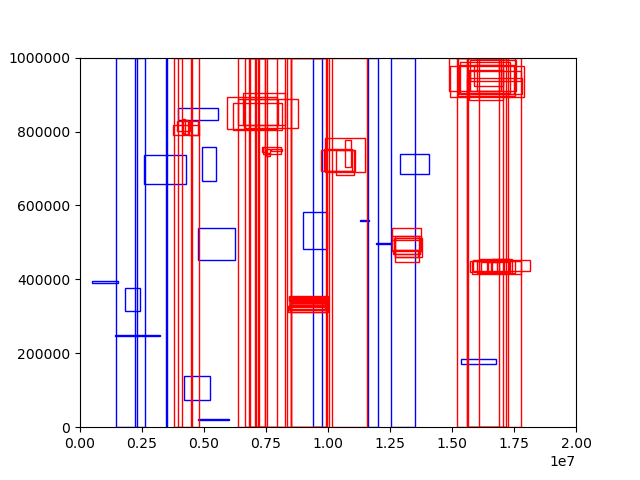

In [46]:
# = = = Global Configuration = = =

scale_factor = 100
prob_threshold = 1 / scale_factor
total_dims = 16 # the dimensions of lineitem table
domain_dims = 8 # the dimensions we used and maintain min max for
chunk_size = 100000 # 0.1M 

# base_table_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/9a84f6cd-727f-4f10-ae95-10a0214e10a4-tpc-h-tool/2.18.0_rc2/dbgen/lineitem_'
# table_path = base_table_path + str(scale_factor) + '.tbl'

base_save_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/dataset/lineitem_'
save_path_data = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '.csv'
save_path_domain = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '_domains.csv'

# by default, the sampled size always equal to 6M (i.e., using scale factor 1), then for a higher scale factor, we need to divide it
block_size = 1000000 // scale_factor # in original file, 1M rows take approximately 128MB

# = = = Data Loading = = =
dataset = np.genfromtxt(save_path_data, delimiter=',') # the sampled subset
domains = np.genfromtxt(save_path_domain, delimiter=',') # the domain of that scale

# Configuration
used_dimensions = [1,2,3,4] # the second and third dimensions

dataset = dataset[:,used_dimensions]
domains = domains[used_dimensions]

# = = = Query Loading = = =
from QueryGeneration import *

# = = = Query Generation = = =

total_queries = 100
random_percentage = 0.20
maximum_random_range = [(domains[i,1] - domains[i,0])*0.1 for i in range(len(domains))]
cluster_amount = 8
maximum_range_dis = [(domains[i,1] - domains[i,0])*0.1 for i in range(len(domains))]
sigmas_percentage = [0.2,0.2,0.2, 0.2]
dimension_probability = [1.0, 0.8, 0.5, 0.5]
random_shift = False
return_seperate = True

# COMMENT THIS IF NOT GENERATING QUERIES
# mixed_queris = generate_query_with_random(total_queries, random_percentage, domains, maximum_random_range, 
#                                           cluster_amount, maximum_range_dis, sigmas_percentage, random_shift, return_seperate)
mixed_queris = generate_query_with_random(total_queries, random_percentage, domains, maximum_random_range, 
                                          cluster_amount, maximum_range_dis, sigmas_percentage, random_shift, 
                                          return_seperate, dimension_probability)

plot_queries_2d_distribution_and_random(mixed_queris[1], mixed_queris[0], domains)
random_query = mixed_queris[0]
distribution_query = mixed_queris[1]

# = = = Query Saving / Loading = = =

# Configuration
query_base_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/NORA/query/'

distribution_path = query_base_path + 'alpha_' + str(int(random_percentage*100)) + '_dims_' + \
    str(len(used_dimensions)) + '_distribution.csv'
random_path = query_base_path + 'alpha_' + str(int(random_percentage*100))  + '_dims_' + \
    str(len(used_dimensions)) + '_random.csv'

random_segmentation = int(total_queries * random_percentage / 2)
distribution_segmentation = int(total_queries * (1 - random_percentage) / 2)

### SELECT THIS ONE ###  save the generated queries
save_query(mixed_queris[0], random_path)
save_query(mixed_queris[1], distribution_path)
training_set = np.concatenate((random_query[0:random_segmentation], distribution_query[0:distribution_segmentation]), axis=0)
testing_set = np.concatenate((random_query[random_segmentation:], distribution_query[distribution_segmentation:]), axis = 0)

### OR THIS ONE ###  load the generated query (if the query is generated from another domain, it should be regenerated!)
# distribution_query = load_query(distribution_path)
# random_query = load_query(random_path)
# training_set = np.concatenate((distribution_query[0:distribution_segmentation], random_query[0:random_segmentation]), axis=0)
# testing_set = np.concatenate((distribution_query[distribution_segmentation:], random_query[random_segmentation:]), axis = 0)

from Query import *
from Utils import *

In [99]:
# distribution_path = query_base_path + 'alpha_' + str(int(random_percentage*100)) + '_dims_' + \
#     str(len(used_dimensions)) + '_distribution.csv'
# random_path = query_base_path + 'alpha_' + str(int(random_percentage*100))  + '_dims_' + \
#     str(len(used_dimensions)) + '_random.csv'
# save_query(mixed_queris[0], random_path)
# save_query(mixed_queris[1], distribution_path)

In [47]:
mixed_queris

[[[[9383490.205784043, 9767247.794215957],
   [1.0, 1000000.0],
   [1.0, 1.2928026046142485],
   [1.0, 50.0]],
  [[3479691.669402638, 3527490.330597362],
   [1.0, 1000000.0],
   [4.9418955379313285, 5.0581044620686715],
   [1.0, 50.0]],
  [[1449299.276307469, 2614226.7236925308],
   [1.0, 1000000.0],
   [1.0, 7.0],
   [1.0, 50.0]],
  [[2213341.1441428214, 2297632.8558571786],
   [1.0, 1000000.0],
   [1.0, 7.0],
   [17.421012196313043, 20.578987803686957]],
  [[11927439.266824892, 12589678.733175108],
   [496895.12372970075, 498580.87627029925],
   [5.983387440101753, 6.016612559898247],
   [21.897154683816478, 26.102845316183522]],
  [[4192604.273947906, 5228937.726052093],
   [73270.13384200812, 139749.86615799187],
   [1.8991654570201455, 2.1008345429798543],
   [1.0, 50.0]],
  [[12548516.64395389, 13498743.35604611],
   [1.0, 1000000.0],
   [1.0, 7.0],
   [1.0, 50.0]],
  [[4764494.344365033, 6237805.655634967],
   [453214.4054752217, 540051.5945247783],
   [2.8314252421118296, 3.168

<IPython.core.display.Javascript object>


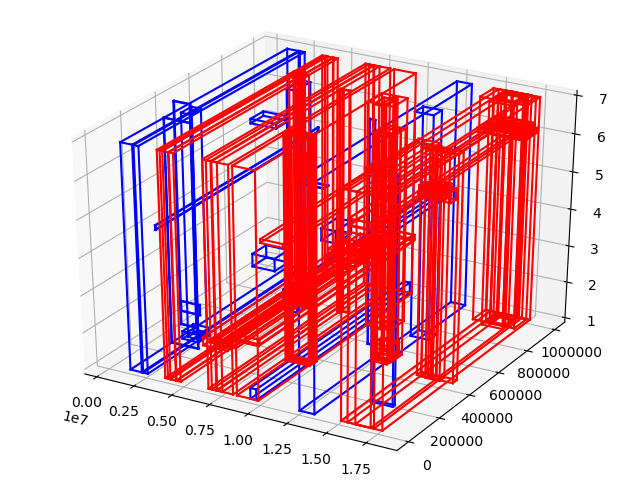

In [48]:
show_queries_3d(mixed_queris[1], mixed_queris[0])

In [49]:
# # Configuration
data_threshold = block_size
query_threshold = 2
# hist_m, hist_n = 300, 1000
buckets = [300, 300, 100, 300]
# nora_partition_base_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/HDFSExperiment/generated_partitions/'
# nora_path = nora_partition_base_path + 'nora_partitions_alpha_' + str(int(random_percentage*100))

# nora_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist = LKD_Robust_Initialization_sub_V3(
#     dataset, training_set, domains, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

# filtered_queries, query_hist = filter_distribution_query_V2_2D(training_set, domains, hist_m, hist_n, query_threshold)

nora_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist = LKD_Robust_Initialization_V4(
    dataset, training_set, domains, data_threshold, query_threshold, buckets, random_percentage)

MemoryError: 

In [110]:
uni_dim3 = np.unique(dataset[:,2], axis=0)

In [111]:
uni_dim3

array([1., 2., 3., 4., 5., 6., 7.])

In [124]:
len(nora_kdnodes)

389

<IPython.core.display.Javascript object>


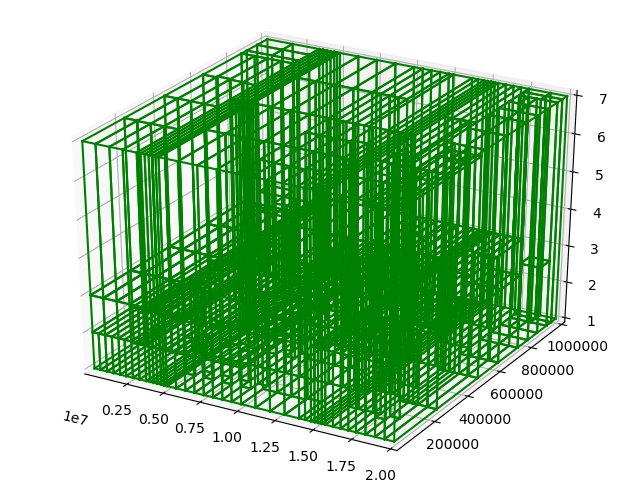

In [125]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# this is the 3D version
def visualize_kdnodes_and_query_3(kdnodes, query_distribution, query_random, domains, dim1 = 0, dim2 = 1, dim3 = 2, path=None):
    
    fig = plt.figure()
    ax = Axes3D(fig)
    
    plt.xlim(domains[dim1][0],domains[dim1][1])
    plt.ylim(domains[dim2][0],domains[dim2][1])
    ax.set_zlim(domains[dim3][0],domains[dim3][1])
    
    for i in range(len(kdnodes)):
        
        L1 = kdnodes[i][0][dim1][0]
        L2 = kdnodes[i][0][dim2][0]
        L3 = kdnodes[i][0][dim3][0]
        U1 = kdnodes[i][0][dim1][1]
        U2 = kdnodes[i][0][dim2][1]
        U3 = kdnodes[i][0][dim3][1]
    
        # the 12 lines to form a rectangle
        x = [L1, U1]
        y = [L2, L2]
        z = [L3, L3]
        ax.plot3D(x,y,z,color="g")
        y = [U2, U2]
        ax.plot3D(x,y,z,color="g")
        z = [U3, U3]
        ax.plot3D(x,y,z,color="g")
        y = [L2, L2]
        ax.plot3D(x,y,z,color="g")
        
        x = [L1, L1]
        y = [L2, U2]
        z = [L3, L3]
        ax.plot3D(x,y,z,color="g")
        x = [U1, U1]
        ax.plot3D(x,y,z,color="g")
        z = [U3, U3]
        ax.plot3D(x,y,z,color="g")
        x = [L1, L1]
        ax.plot3D(x,y,z,color="g")
        
        x = [L1, L1]
        y = [L2, L2]
        z = [L3, U3]
        ax.plot3D(x,y,z,color="g")
        x = [U1, U1]
        ax.plot3D(x,y,z,color="g")
        y = [U2, U2]
        ax.plot3D(x,y,z,color="g")
        x = [L1, L1]
        ax.plot3D(x,y,z,color="g")
    
    for i in range(len(query_random)):
        
        L1 = query_random[i][dim1][0]
        L2 = query_random[i][dim2][0]
        L3 = query_random[i][dim3][0]
        U1 = query_random[i][dim1][1]
        U2 = query_random[i][dim2][1]
        U3 = query_random[i][dim3][1]
        
        # the 12 lines to form a rectangle
        x = [L1, U1]
        y = [L2, L2]
        z = [L3, L3]
        ax.plot3D(x,y,z,color="b")
        y = [U2, U2]
        ax.plot3D(x,y,z,color="b")
        z = [U3, U3]
        ax.plot3D(x,y,z,color="b")
        y = [L2, L2]
        ax.plot3D(x,y,z,color="b")
        
        x = [L1, L1]
        y = [L2, U2]
        z = [L3, L3]
        ax.plot3D(x,y,z,color="b")
        x = [U1, U1]
        ax.plot3D(x,y,z,color="b")
        z = [U3, U3]
        ax.plot3D(x,y,z,color="b")
        x = [L1, L1]
        ax.plot3D(x,y,z,color="b")
        
        x = [L1, L1]
        y = [L2, L2]
        z = [L3, U3]
        ax.plot3D(x,y,z,color="b")
        x = [U1, U1]
        ax.plot3D(x,y,z,color="b")
        y = [U2, U2]
        ax.plot3D(x,y,z,color="b")
        x = [L1, L1]
        ax.plot3D(x,y,z,color="b")
        
        
    for i in range(len(query_distribution)):
        L1 = query_distribution[i][dim1][0]
        L2 = query_distribution[i][dim2][0]
        L3 = query_distribution[i][dim3][0]
        U1 = query_distribution[i][dim1][1]
        U2 = query_distribution[i][dim2][1]
        U3 = query_distribution[i][dim3][1]
        
        # the 12 lines to form a rectangle
        x = [L1, U1]
        y = [L2, L2]
        z = [L3, L3]
        ax.plot3D(x,y,z,color="r")
        y = [U2, U2]
        ax.plot3D(x,y,z,color="r")
        z = [U3, U3]
        ax.plot3D(x,y,z,color="r")
        y = [L2, L2]
        ax.plot3D(x,y,z,color="r")
        
        x = [L1, L1]
        y = [L2, U2]
        z = [L3, L3]
        ax.plot3D(x,y,z,color="r")
        x = [U1, U1]
        ax.plot3D(x,y,z,color="r")
        z = [U3, U3]
        ax.plot3D(x,y,z,color="r")
        x = [L1, L1]
        ax.plot3D(x,y,z,color="r")
        
        x = [L1, L1]
        y = [L2, L2]
        z = [L3, U3]
        ax.plot3D(x,y,z,color="r")
        x = [U1, U1]
        ax.plot3D(x,y,z,color="r")
        y = [U2, U2]
        ax.plot3D(x,y,z,color="r")
        x = [L1, L1]
        ax.plot3D(x,y,z,color="r")
    
    if path != None:
        fig.savefig(path)
    
    plt.show()
    
visualize_kdnodes_and_query_3(nora_kdnodes, [], [], domains)

In [119]:
nora_kdnodes[0]

[array([[1.00000e+00, 5.00355e+06],
        [1.00000e+00, 1.00000e+06],
        [1.00000e+00, 7.00000e+00]]), 1500328, 3, 1, 5, 6]

In [97]:
for i in range(len(nora_kdnodes)):
    if nora_kdnodes[i][0][0][0] == nora_kdnodes[i][0][0][1] or nora_kdnodes[i][0][1][0] == nora_kdnodes[i][0][1][1] or\
    nora_kdnodes[i][0][2][0] == nora_kdnodes[i][0][2][1]:
        print("invalid",i,nora_kdnodes[i])

invalid 26 [array([[1.0003986e+07, 2.0000000e+07],
       [4.9970000e+05, 7.4990900e+05],
       [1.0000000e+00, 1.0000000e+00]]), 187793, 59, 57, -1, -1]


In [126]:
Query(testing_set, nora_kdnodes, random_percentage)

Query 0  Cost:  58138  Intersected Partitions: [195, 237, 238]
Query 1  Cost:  46316  Intersected Partitions: [203, 204, 217, 218]
Query 2  Cost:  68573  Intersected Partitions: [173, 174, 177, 193]
Query 3  Cost:  246112  Intersected Partitions: [308, 309, 310, 314, 315, 316, 317, 319, 321, 322, 329, 331, 333, 334, 341, 342, 343]
Query 4  Cost:  104253  Intersected Partitions: [197, 199, 201, 203, 213, 217]
Query 5  Cost:  106994  Intersected Partitions: [56, 59, 62, 63, 70, 72, 74, 75]
Query 6  Cost:  113415  Intersected Partitions: [191, 192, 196, 240, 242, 243, 244]
Query 7  Cost:  89456  Intersected Partitions: [295, 298, 305, 306, 307, 311, 313]
Query 8  Cost:  139001  Intersected Partitions: [198, 200, 202, 204, 205, 207, 209, 211]
Query 9  Cost:  85742  Intersected Partitions: [351, 353, 355, 361, 363]
Query 10  Cost:  32362  Intersected Partitions: [342, 343]
Query 11  Cost:  64931  Intersected Partitions: [349, 360, 361, 362]
Query 12  Cost:  381860  Intersected Partitions: [

In [127]:
# KDT

current_dim = 0
data_threshold = block_size
root_node = [domains, len(dataset), 0, -1, -1, -1] # sub_domains, len(sub_dataset1), id, parent_id, left_child_id, right_child_id
kdt_kdnode_dict = {}
kdt_accu_count_list = [0]

kdtree_kdnodes = KDPartition(dataset, current_dim, data_threshold, root_node, kdt_kdnode_dict, kdt_accu_count_list)

In [128]:
Query(testing_set, kdtree_kdnodes, random_percentage)

Query 0  Cost:  93782  Intersected Partitions: [216, 217, 218, 219, 435, 436, 437]
Query 1  Cost:  93873  Intersected Partitions: [314, 315, 316, 317, 318, 319, 320, 321]
Query 2  Cost:  130318  Intersected Partitions: [163, 166, 170, 171, 216, 217, 218, 219, 222, 223]
Query 3  Cost:  130607  Intersected Partitions: [296, 297, 300, 301, 310, 311, 347, 348, 349, 354]
Query 4  Cost:  140749  Intersected Partitions: [238, 239, 246, 251, 253, 314, 315, 318, 319, 322, 324]
Query 5  Cost:  60151  Intersected Partitions: [133, 134, 195, 197]
Query 6  Cost:  120611  Intersected Partitions: [186, 190, 230, 231, 235, 383, 393, 447, 448, 454]
Query 7  Cost:  80375  Intersected Partitions: [280, 281, 291, 340, 341, 345]
Query 8  Cost:  140746  Intersected Partitions: [242, 243, 252, 257, 258, 270, 316, 317, 323, 326, 327, 334]
Query 9  Cost:  70342  Intersected Partitions: [304, 305, 312, 350, 351, 356]
Query 10  Cost:  70327  Intersected Partitions: [296, 297, 310, 347, 354]
Query 11  Cost:  1206

<IPython.core.display.Javascript object>


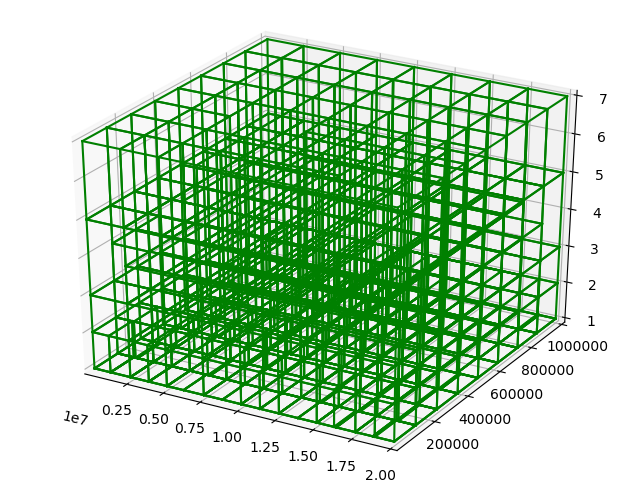

In [130]:
visualize_kdnodes_and_query_3(kdtree_kdnodes, [], [], domains)

In [133]:
# Test Qd-Tree
def QDT(dataset, queryset, domains, data_threshold, buckets, show_step = False):
    
    candidate_cut_pos = generate_candidate_cut_pos(queryset)
    
    p = index.Property()
    p.dimension = len(buckets)
    p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.5
    p.overwrite = True

    idx = index.Index(DatasetGenerator(queryset), properties = p) # Rtree index for queries, ONLY these queries
    
    hist, edges = np.histogramdd(dataset, bins = tuple(buckets))
    accu_hist = CreatePrefixSumHist(hist) # this one use the multi-dimensional version
    
    accu_count_list = [0]
    
    root_node = [domains, len(dataset), 0, -1, -1, -1]
    kdnode_dict = {0:root_node}
    
    processed_kdnodes = LKD(candidate_cut_pos, idx, accu_hist, dataset, queryset, domains, data_threshold, 
                            accu_count_list, kdnode_dict, root_node, show_step)
    return processed_kdnodes

qdtree_kdnodes = QDT(dataset, training_set, domains, block_size, buckets)

= = = current try split kdnode: [[1.e+00 2.e+07]
 [1.e+00 1.e+06]
 [1.e+00 7.e+00]]
= = = current try split kdnode: [[1.00000000e+00 1.26128728e+07]
 [1.00000000e+00 1.00000000e+06]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.26128728e+07 2.00000000e+07]
 [1.00000000e+00 1.00000000e+06]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.00000000e+00 4.61185339e+06]
 [1.00000000e+00 1.00000000e+06]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.26128728e+07 1.58358369e+07]
 [1.00000000e+00 1.00000000e+06]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[4.61185339e+06 1.26128728e+07]
 [1.00000000e+00 1.00000000e+06]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.58358369e+07 2.00000000e+07]
 [1.00000000e+00 1.00000000e+06]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.0000000e+00 3.5791973e+06]
 [1.0000000e+00 1.0000000e+06]
 [1.0000000e+00 7.0000000e+00]

= = = current try split kdnode: [[1.58358369e+07 1.86212263e+07]
 [8.80225860e+05 1.00000000e+06]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.00000000e+00 3.57919730e+06]
 [3.67132681e+05 8.50347378e+05]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.26128728e+07 1.46874147e+07]
 [7.31861965e+05 8.36104086e+05]
 [1.00000000e+00 5.26105361e+00]]
= = = current try split kdnode: [[6.34558586e+06 1.05537820e+07]
 [1.00000000e+00 1.99623273e+05]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[3.57919730e+06 4.61185339e+06]
 [6.04283754e+05 6.77771348e+05]
 [1.00000000e+00 3.03998023e+00]]
= = = current try split kdnode: [[1.26128728e+07 1.46210967e+07]
 [7.25586064e+05 1.00000000e+06]
 [5.26107361e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.05537820e+07 1.26128728e+07]
 [1.32692727e+05 2.94588673e+05]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.78796967e+07 2.00000000e+07]
 [4.0002180

= = = current try split kdnode: [[3.57919730e+06 3.80490904e+06]
 [1.00000000e+00 6.04283754e+05]
 [4.73894639e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.46210967e+07 1.58358369e+07]
 [4.76832066e+05 1.00000000e+06]
 [5.26107361e+00 6.63639080e+00]]
= = = current try split kdnode: [[1.26128728e+07 1.46874147e+07]
 [8.36104086e+05 1.00000000e+06]
 [1.00000000e+00 5.26105361e+00]]
= = = current try split kdnode: [[3.57919730e+06 3.80490904e+06]
 [6.77771348e+05 1.00000000e+06]
 [1.00000000e+00 3.03998023e+00]]
= = = current try split kdnode: [[1.05537820e+07 1.26128728e+07]
 [2.94588673e+05 3.26169331e+05]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.78796967e+07 2.00000000e+07]
 [6.30660652e+05 8.80225860e+05]
 [1.00000000e+00 4.73892639e+00]]
= = = current try split kdnode: [[1.46874147e+07 1.58358369e+07]
 [5.46691934e+05 1.00000000e+06]
 [1.00000000e+00 5.26105361e+00]]
= = = current try split kdnode: [[1.81472793e+07 2.00000000e+07]
 [2.7859093

= = = current try split kdnode: [[3.57919730e+06 3.80490904e+06]
 [1.00000000e+00 6.04283754e+05]
 [1.00000000e+00 3.03998023e+00]]
= = = current try split kdnode: [[1.26128728e+07 1.37085754e+07]
 [1.00000000e+00 7.25586064e+05]
 [5.26107361e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.05537820e+07 1.26128728e+07]
 [1.00000000e+00 6.78937486e+04]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.58358369e+07 1.59491811e+07]
 [4.00021805e+05 8.80225860e+05]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.00000000e+00 1.84286052e+06]
 [8.50347378e+05 8.82380072e+05]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.46874147e+07 1.58358369e+07]
 [1.00000000e+00 4.76832066e+05]
 [1.00000000e+00 5.26105361e+00]]
= = = current try split kdnode: [[4.61185339e+06 1.05537820e+07]
 [1.99623273e+05 1.00000000e+06]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.58358369e+07 1.75401098e+07]
 [2.7859093

= = = current try split kdnode: [[3.57919730e+06 3.80490904e+06]
 [1.00000000e+00 6.04283754e+05]
 [1.00000000e+00 3.03998023e+00]]
= = = current try split kdnode: [[1.26128728e+07 1.37085754e+07]
 [1.00000000e+00 7.25586064e+05]
 [5.26107361e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.05537820e+07 1.26128728e+07]
 [1.00000000e+00 6.78937486e+04]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.58358369e+07 1.59491811e+07]
 [4.00021805e+05 8.80225860e+05]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.00000000e+00 1.84286052e+06]
 [8.50347378e+05 8.82380072e+05]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.46874147e+07 1.58358369e+07]
 [1.00000000e+00 4.76832066e+05]
 [1.00000000e+00 5.26105361e+00]]
= = = current try split kdnode: [[4.61185339e+06 1.05537820e+07]
 [1.99623273e+05 1.00000000e+06]
 [1.00000000e+00 7.00000000e+00]]
= = = current try split kdnode: [[1.58358369e+07 1.75401098e+07]
 [2.7859093

In [135]:
len(qdtree_kdnodes)
Query(testing_set, qdtree_kdnodes, random_percentage)

Query 0  Cost:  1791971  Intersected Partitions: [10, 14]
Query 1  Cost:  547408  Intersected Partitions: [1, 21, 34]
Query 2  Cost:  1428982  Intersected Partitions: [10]
Query 3  Cost:  578834  Intersected Partitions: [3, 9, 11, 13, 27, 37, 50, 59]
Query 4  Cost:  517687  Intersected Partitions: [1, 5, 6, 34]
Query 5  Cost:  544026  Intersected Partitions: [16, 19, 26]
Query 6  Cost:  1845199  Intersected Partitions: [10, 14, 28, 47]
Query 7  Cost:  518650  Intersected Partitions: [3, 9, 13, 27]
Query 8  Cost:  1546834  Intersected Partitions: [10, 21, 42]
Query 9  Cost:  64078  Intersected Partitions: [45]
Query 10  Cost:  42546  Intersected Partitions: [11, 37, 59]
Query 11  Cost:  61236  Intersected Partitions: [22, 25, 55]
Query 12  Cost:  833412  Intersected Partitions: [3, 15, 22, 29, 43, 45, 48, 53, 65]
Query 13  Cost:  49768  Intersected Partitions: [24, 27, 39, 54]
Query 14  Cost:  34047  Intersected Partitions: [27, 33]
Query 15  Cost:  152506  Intersected Partitions: [15, 

<IPython.core.display.Javascript object>


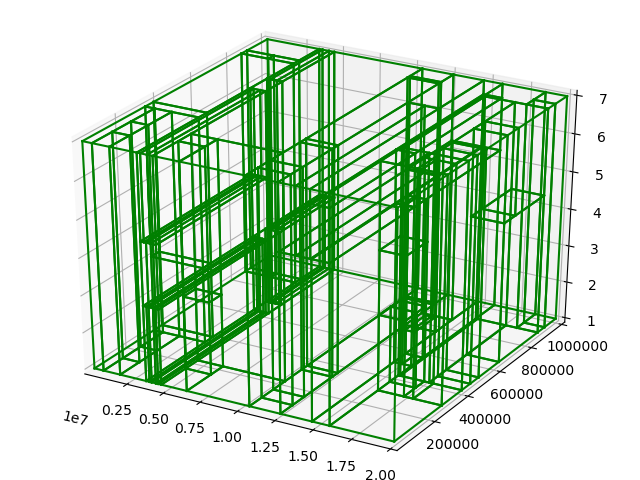

In [136]:
visualize_kdnodes_and_query_3(qdtree_kdnodes, [], [], domains)

In [472]:
# === KDTree Visualization ===
#
# restricted to 2D
#
# @kdnodes: the generated kdnodes, domains in them are ordered according to the learned split dimension order,
#   should only generated on the domains for visualization?
# @query: the query in the query dimension order, should be the same as the order of 'kdnode domains'
# @domains: the domains for visualization, should be in the origin order
# @realtive_order: whether to adjust the order of domains in kdnodes to corresponding the 'domains' parameteer
#
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
def visualize_kdnodes_and_query(kdnodes, query, domains):
    
    fig, ax = plt.subplots(1)
    
    plt.xlim(domains[0][0],domains[0][1])
    plt.ylim(domains[1][0],domains[1][1])
    # transform the queries into boxes
    
    # first plot all the kdnodes
    for i in range(len(kdnodes)):
        
        kd_domains = kdnodes[i][0]
        kd_domains = np.asarray(kd_domains)
        
        lower1 = kd_domains[0][0]
        upper1 = kd_domains[0][1]
        lower2 = kd_domains[1][0]
        upper2 = kd_domains[1][1]
        
        rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='b',linewidth=1)
        ax.add_patch(rect)
    
    # plot the queries
    for i in range(len(query)):
        
        lower1 = query[i][0][0]
        upper1 = query[i][0][1]
        lower2 = query[i][1][0]
        upper2 = query[i][1][1]
        
        rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='r',linewidth=3)
        ax.add_patch(rect)
        
    plt.show()

In [498]:
# LKD_Robust_kdnodes = []
# for key,value in kdnode_dict.items():
#     if value[-1] == -1 and value[-2] == -1:
#         LKD_Robust_kdnodes.append(value)

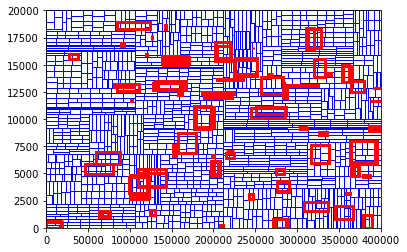

In [499]:
# visualize_kdnodes_and_query(LKD_Robust_kdnodes, continous_fusion_query[-100:], domains_)

In [500]:
# # Test Query Cost
# Query(continous_fusion_query[-100:], LKD_Robust_kdnodes)

average partitions each query overlap(average):  7.76
average records each query retrieve(average):  55316.46
total records that all the queries retrieve:  5531646


In [ ]:
# # consider the baseline of using the last 100 queries
# qd_root_node = [domains_, len(dataset), 0, -1, -1, -1]
# qd_kdnode_dict = {}
# pure_Qd_Tree_kdnodes = LKD_Robust(dataset, queryset, domains, min_block_size, (1000,1000), accu_count_list, qd_kdnode_dict, qd_root_node)